In [3]:
!pip install modAL

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import csv
import time
import pickle
import pandas as pd
import numpy as np
import numpy.ma as ma
from functools import partial
import seaborn as sn

from collections import defaultdict, Counter

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

from modAL.models import ActiveLearner
from modAL.uncertainty import *
from modAL.batch import uncertainty_batch_sampling


import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [5]:
filePathName = './RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [7]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

dict_label_list = [k for k,v in sorted(dict_label.items(), key = lambda x: x[1])]
print(dict_label_list)

['numeric', 'categorical', 'datetime', 'sentence', 'url', 'embedded-number', 'list', 'not-generalizable', 'context-specific']


In [8]:
def ProcessStats(data,y):

    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')

def FeatureExtraction(data,data1,flag):

    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    #print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    #print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    #print(len(data2))
    return data2



In [9]:
def get_data(sim_size = 0.8):
    """
    sim_size is the % of training data that goes into simulation set.
    """
    xtrain = pd.read_csv('./data_train.csv')
    xtest = pd.read_csv('./data_test.csv')

    y_train = xtrain.loc[:,['y_act']]
    y_test = xtest.loc[:,['y_act']]
    y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
    y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]
    
    xtrain1 = ProcessStats(xtrain,y_train)
    xtest1 = ProcessStats(xtest,y_test)


    X_train = FeatureExtraction(xtrain,xtrain1,1)
    X_test = FeatureExtraction(xtest,xtest1,0)


    X_train_new = X_train.reset_index(drop=True)
    y_train_new = y_train.reset_index(drop=True)
    X_train_new = X_train_new.values
    y_train_new = y_train_new.values
    
    # setting up data
    X_train_AL, X_simulation_AL, y_train_AL, y_simulation_AL = train_test_split(X_train_new, y_train, test_size=sim_size, stratify = y_train)
    # Start AL loops simulated with a part of the test data
    X_simulation_df = pd.DataFrame(X_simulation_AL)
    y_simulation_df = pd.DataFrame(y_simulation_AL)
    # making copies of existing X_test and y_test data
    X_test_AL = pd.DataFrame(X_test)
    y_test_AL = pd.DataFrame(y_test)
    
    assert len(X_train_AL) == len(y_train_AL)
    assert len(X_simulation_df) == len(y_simulation_df)
    assert len(X_test_AL) == len(y_test_AL)
    return X_train_AL, y_train_AL, X_simulation_df, y_simulation_df, X_test_AL, y_test_AL

X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
print(f"Training set size: {len(X_train)}, Simulation set size: {len(X_sim)}, Test set size: {len(X_test)}")


Training set size: 1587, Simulation set size: 6349, Test set size: 1985


In [10]:
X_train

array([[81106, 0, 0.0, ..., 0, 0, 0],
       [1518, 0, 0.0, ..., 0, 0, 0],
       [1518, 0, 0.0, ..., 0, 0, 0],
       ...,
       [420551, 0, 0.0, ..., 0, 0, 0],
       [9597, 326, 3.39689486, ..., 0, 0, 0],
       [134, 0, 0.0, ..., 0, 0, 0]], dtype=object)

In [8]:
print(X_train.shape, y_train.shape)
print(X_sim.shape, y_sim.shape)
print(X_test.shape, y_test.shape)

(1587, 1478) (1587, 1)
(6349, 1478) (6349, 1)
(1985, 1478) (1985, 1)


In [9]:
def grid_parameter_search(X_train, y_train, X_test, y_test, n_estimators_grid, max_depth_grid, query_size):
    best_model_score = 0
    
    preset_batch = partial(uncertainty_sampling, n_instances=query_size)
    
    for ne in n_estimators_grid:
        for md in max_depth_grid:
            learner = ActiveLearner(
                  estimator=RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=100),
                  X_training=X_train, y_training=y_train,
                  query_strategy=preset_batch
                )
            score = learner.score(X_test, y_test)
            print(f"[n_estimator: {ne}, max_depth: {md}, accuracy: {score}]")
            if best_model_score < score:
                best_ne = ne
                best_md = md
                best_model_score = score
                bestPerformingModel = learner
    print(f"best model found at ne:{best_ne}, md:{best_md}, at score:{best_model_score}")
    return learner, best_ne, best_md, best_model_score


#learner, best_ne, best_md, best_model_score = grid_parameter_search(X_train, y_train, X_sim, y_sim, [i*100 for i in range(1,11)],[i*100 for i in range(11)], 100)
#print(f"[BEST OBTAINED RF ESTIMATOR] === [n_estimator: {best_ne}, max_depth: {best_md}, accuracy: {best_model_score}]")

In [10]:
def save_his(data, full_path):
    assert data != None and len(data.items()) > 0, "data should not be empty"
    
    with open(full_path, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(list(data.keys()))
        writer.writerows(zip(*data.values()))
    

test_data_1 = [i for i in range(100)]
test_data_2 = [i*2 for i in range(100)]
test_data_3 = [i*3 for i in range(100)]
test_data_4 = [i*4 for i in range(100)]
data = {"num_queries": test_data_1, "time": test_data_2, "total_time":test_data_3, "test_accuracy":test_data_4}

save_his(data, "./his/test.csv")

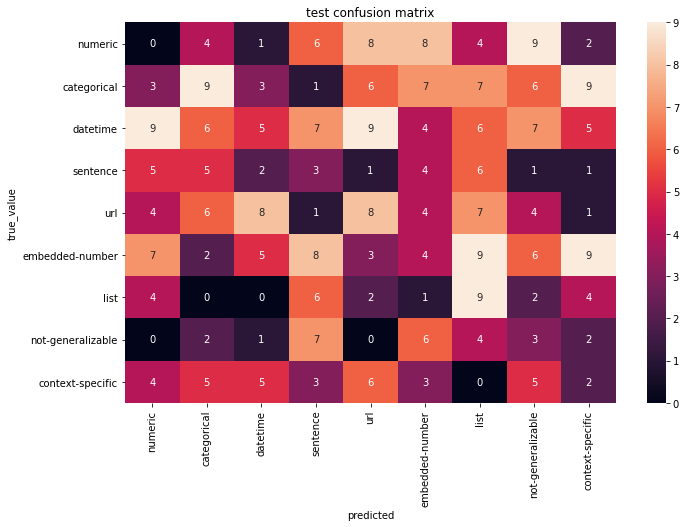

In [11]:
con_matrix = np.random.randint(0,10,(9,9),)
title = "test confusion matrix"
img_folder = "./img"

def save_con_matrix(con_matrix, title, full_path, show=False):
    plt.figure(figsize = (11,7))
    df_cm = pd.DataFrame(con_matrix, index = dict_label_list, columns = dict_label_list)
    sn.heatmap(con_matrix, annot=True, fmt="g", xticklabels=dict_label_list, yticklabels=dict_label_list,) # font size

    plt.title(title) # title with fontsize 20
    plt.xlabel('predicted') # x-axis label with fontsize 15
    plt.ylabel('true_value') # y-axis label with fontsize 15

    plt.savefig(full_path)

save_con_matrix(con_matrix, title, img_folder + "/test_matrix.png")

In [12]:
feed_his_folder = "./feed"

test_feed = np.random.rand(9,9)

def save_feed(feed, full_path):
    file = open(full_path, 'wb')
    pickle.dump(feed, file)
    
def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

save_feed(test_feed, feed_his_folder+"/test.pkl")
re = load_feed(feed_his_folder+"/test.pkl")

assert np.all(test_feed == re)

In [13]:
his_folder = "./his"
img_folder = "./img"
feed_folder = "./feed"

def per_class_acc(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return matrix.diagonal()/matrix.sum(axis=1)

def train_this(n_est, max_dept, query_size, max_feed, per_iteration_acc_report = True, feed_his = None):
    
    # getting data
    X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
    
    # get learner
    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(\
    estimator=RandomForestClassifier(n_estimators=n_est, max_depth=max_dept, random_state=100),
        X_training=X_train, y_training=y_train,
        query_strategy=preset_batch
        )
    
    # init tracker lists
    num_queries = [0]
    time_history = [0]
    total_time_history = [0]
    train_acc_history = [learner.score(X_train, y_train)]
    sim_acc_history = [learner.score(X_sim, y_sim)]
    test_acc_history = [learner.score(X_test, y_test)]
    per_class_acc_history = [per_class_acc(y_test, learner.predict(X_test))]
    feed_to_learner = []
    
    print(f"learner trained_acc:{train_acc_history}, sim_acc:{sim_acc_history}, test_acc:{test_acc_history}")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"base line decision tree classifier (n_est = {n_est}, max_dept = {max_dept})"
    save_con_matrix(con_matrix, title, f"{img_folder}/baseline.png")
    
    # AL cycle
    t_start = time.time()
    
    while len(feed_to_learner) * query_size < max_feed :
        current_count = len(feed_to_learner) * query_size
        print(f"\n*********** QUERY {current_count} *********** remain:{len(X_sim)}")
        t0 = time.time()
        
        #AL selection
        query_idx = []
        
        if feed_his:
            query_idx = feed_his[0]
            feed_his = feed_his[1:]
        else:
            query_idx, _ = learner.query(np.array(X_sim))
            if current_count + len(query_idx) > max_feed:
                query_idx = query_idx[:current_count + len(query_idx) - max_feed]
                #query_inst = query_inst[:current_count + len(query_idx) - max_feed] 
            
        print(f"Nodes returned for query in query {current_count}: {query_idx}")

        #updating learner
        learner.teach(X = X_sim.iloc[query_idx], y = y_sim.iloc[query_idx])
        feed_to_learner.append(list(query_idx))
        
        X_sim = X_sim.drop(X_sim.index[query_idx])
        y_sim = y_sim.drop(y_sim.index[query_idx])

        #df version
        # delete queries that have been looped back into the model
        #X_simulation_df = X_simulation_df.drop(X_simulation_df.index[query_idx])
        #y_simulation_df = y_simulation_df.drop(y_simulation_df.index[query_idx])

        #np version
        # learner.teach(X = pd.Series(X_simulation_np[idx]), y = y_simulation_np[idx])
        # X_simulation_np = np.delete(X_simulation_np, query_index, axis=0)
        # y_simulation_np = np.delete(y_simulation_np, query_index)
        
        # recording history
        t1 = time.time()
        time_history.append(t1 - t0)
        total_time_history.append(t1 - t_start)
        num_queries.append(len(feed_to_learner)* query_size)

        # Calculate and report our model's accuracy.
        if per_iteration_acc_report and len(X_sim) > 0:
            test_acc = learner.score(X_test, y_test)
            sim_acc = learner.score(X_sim, y_sim)
            class_acc = per_class_acc(y_test, learner.predict(X_test))
            #train_acc = learner.score(X_train, y_train)
                
            test_acc_history.append(  test_acc  )
            sim_acc_history.append(   sim_acc   )
            #train_acc_history.append( train_acc )
            per_class_acc_history.append( class_acc )
            print(f"\n[INTERMEDIATE] test_acc:{test_acc}, sim_acc:{sim_acc}, per_class_acc {class_acc}")
            
        print(f"\n[INTERMEDIATE] Time taken for query {current_count}: {time_history[-1]}")
        print(f"\n[INTERMEDIATE] Total time taken {current_count}: {total_time_history[-1]}")

    # saving data into csv
    print("saving data")
    
    al_sampling = "Uncertainty_Batch_Sampling"
    file_name = f"{al_sampling}_ne{n_est}_dept{max_dept}_query{query_size}"
    
    data = {"num_queries": num_queries, "time": time_history, "total_time":total_time_history,\
            #"train_accuracy":train_acc_history, \
            "simulation_accuracy":sim_acc_history,\
            "test_accuracy":test_acc_history}
    save_his(data, f"{his_folder}/{file_name}.csv")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"AL using decision tree classifier (n_est = {n_est}, max_dept = {max_dept}) with {al_sampling} (query_size = {query_size})"
    save_con_matrix(con_matrix, title, f"{img_folder}/{file_name}.png")
    
    # saving feed into pickle
    save_feed(feed_to_learner, f"{feed_folder}/{file_name}.pkl")
    save_feed(per_class_acc_history, f"{his_folder}/class_his_{file_name}.pkl")
        
    print("completed")
    
#train_this(n_est=400, max_dept=100, query_size=10)

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.898094188061112], test_acc:[0.8952141057934508]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477, 3924, 1288, 4036, 5130, 894, 6165, 181, 4038, 3314, 2780, 2289, 1028, 396, 3863, 5739, 865, 3165, 2647, 3999, 5847, 5323, 5856, 6069, 4853, 1520, 1895, 5384, 5245, 5097, 5941, 3290, 2985, 3648, 6088, 4289, 757, 5970, 3466, 830, 3959, 2723, 4238, 2181, 5772, 2808, 2550, 6344, 126, 3651, 4703, 3753, 354, 832, 2315, 5106, 4722, 5398, 149, 6181, 3951, 5347, 4433, 3871, 3246, 2351, 177, 389, 2405, 5533, 1560, 4557, 3326, 4295, 1309, 1947, 530, 3817, 3639, 775, 2655, 3746, 4403, 1998, 4392, 573, 2139, 2064, 2856, 6048, 3800, 50, 4699, 3559, 5329, 164, 2365, 2358, 1041, 5406]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8957178841309824, sim_acc:0.8969435109617538, per_class_acc [0.97312588 0.93435449 0.92907801 0.83695652 0.875      0.8989899
 0.70175439 0.8744186  0.59459459]

[INTERMEDIATE] Time taken for query 0: 2.561727285385132

[INTERMEDIATE] Total time taken 0: 2.561922073364258

*********** QUERY 100 *********** remain:6249
Nodes returned for query in query 100: [1717, 3236, 236, 6175, 3745, 3269, 2414, 1830, 916, 4637, 4913, 739, 6244, 836, 5294, 3496, 569, 1437, 2269, 5866, 2951, 1736, 5589, 2353, 5903, 1456, 2940, 1438, 672, 4358, 4299, 4502, 5887, 3976, 14, 6130, 4474, 2915, 1218, 2124, 5758, 4787, 888, 553, 3715, 567, 5835, 883, 2975, 2530, 3990, 4410, 1153, 4398, 4811, 1209, 1624, 3521, 2793, 3018, 4970, 3512, 3810, 5021, 4218, 4009, 3910, 1068, 4580, 1765, 354, 5354, 4463, 3755, 4125, 3703, 2878, 5328, 4829, 6184, 5935, 5253, 3904, 5009, 4512, 4445, 400, 4155, 1544, 3536, 3417, 5345, 3834, 5900, 2886, 961, 6207, 4085, 2892, 5473]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8957178841309824, sim_acc:0.900471621401854, per_class_acc [0.96746818 0.93654267 0.93617021 0.82608696 0.9375     0.90909091
 0.68421053 0.86511628 0.61081081]

[INTERMEDIATE] Time taken for query 100: 2.5635359287261963

[INTERMEDIATE] Total time taken 100: 6.687772274017334

*********** QUERY 200 *********** remain:6149
Nodes returned for query in query 200: [4791, 1161, 5948, 3281, 3574, 5801, 5902, 271, 453, 1396, 1146, 962, 728, 4671, 4851, 5483, 3008, 1496, 3717, 5119, 3583, 3133, 687, 5344, 2252, 415, 4499, 1316, 258, 5991, 127, 1132, 1412, 6131, 5315, 1235, 2472, 546, 2786, 1386, 1453, 5977, 1400, 3171, 1935, 2069, 762, 2591, 5704, 5078, 4754, 1069, 1990, 5565, 3481, 5094, 3363, 647, 1550, 4010, 1668, 1415, 5337, 179, 2646, 5551, 2807, 5653, 4241, 4437, 3668, 3988, 3057, 3829, 3799, 3096, 4794, 3634, 244, 4055, 5742, 3605, 3300, 360, 85, 4163, 671, 5835, 3118, 1037, 5709, 823, 2962, 1670, 1606, 3127, 1423, 2700, 2544, 2011]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8997481108312343, sim_acc:0.9042816994544552, per_class_acc [0.9688826  0.9321663  0.92907801 0.81521739 0.96875    0.90909091
 0.70175439 0.88372093 0.63783784]

[INTERMEDIATE] Time taken for query 200: 2.7896087169647217

[INTERMEDIATE] Total time taken 200: 10.94507384300232

*********** QUERY 300 *********** remain:6049
Nodes returned for query in query 300: [1905, 4120, 140, 204, 1258, 2968, 640, 3652, 4970, 214, 1918, 2359, 5955, 4902, 3410, 3897, 1155, 3334, 4512, 2989, 271, 5090, 1264, 394, 720, 4762, 4221, 4669, 3823, 2129, 505, 4412, 2975, 1122, 2942, 3113, 5545, 3664, 3510, 3841, 4347, 1095, 4519, 2003, 1189, 5838, 2909, 778, 5208, 2201, 3079, 671, 5485, 380, 216, 1411, 2708, 1818, 4075, 4560, 2349, 2297, 455, 5618, 4556, 1285, 1885, 5234, 3874, 1318, 5972, 5560, 4647, 179, 5232, 310, 335, 5197, 6033, 1148, 3330, 1738, 4945, 5869, 5476, 3500, 2035, 2370, 5354, 1184, 1655, 3007, 5739, 1854, 672, 4216, 3378, 3184, 5482, 40]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8992443324937027, sim_acc:0.9051941502773575, per_class_acc [0.96605375 0.93654267 0.90070922 0.86956522 0.90625    0.91919192
 0.70175439 0.8744186  0.64324324]

[INTERMEDIATE] Time taken for query 300: 2.9673240184783936

[INTERMEDIATE] Total time taken 300: 15.541127920150757

*********** QUERY 400 *********** remain:5949
Nodes returned for query in query 400: [5610, 2516, 3937, 793, 4474, 2762, 1322, 5312, 4818, 765, 383, 762, 186, 1403, 1271, 5798, 747, 4672, 2336, 4848, 3166, 2704, 3772, 2101, 4544, 5277, 454, 2077, 555, 2159, 2962, 3200, 3529, 3261, 3674, 2848, 4196, 997, 1638, 3719, 5117, 1735, 878, 5325, 612, 82, 151, 4132, 3442, 5263, 1360, 5746, 5086, 2008, 4460, 3173, 2546, 3794, 4467, 3589, 5057, 1928, 54, 2952, 3165, 4338, 5616, 4343, 1335, 628, 3148, 3232, 1968, 385, 4638, 3606, 1084, 5879, 3609, 5799, 1843, 3584, 3813, 3664, 2471, 3869, 1297, 2662, 1609, 390, 505, 2559, 3826, 2102, 5248, 5358, 3543, 1585, 2581, 3287]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9032745591939546, sim_acc:0.910241066849034, per_class_acc [0.97171146 0.92778993 0.92198582 0.85869565 0.9375     0.91919192
 0.70175439 0.89302326 0.64864865]

[INTERMEDIATE] Time taken for query 400: 3.090169668197632

[INTERMEDIATE] Total time taken 400: 20.181653022766113

*********** QUERY 500 *********** remain:5849
Nodes returned for query in query 500: [5748, 2876, 2554, 48, 545, 3675, 5365, 1728, 5790, 5626, 3572, 250, 1746, 5533, 3248, 4308, 2799, 5057, 1122, 2533, 4200, 239, 1371, 4297, 2301, 793, 3567, 5429, 1348, 2760, 4688, 5768, 738, 3628, 2552, 4760, 1464, 1471, 3753, 2665, 1507, 1184, 1251, 2639, 4994, 4992, 4648, 2091, 1490, 4752, 2097, 1341, 2946, 2141, 4165, 2667, 4816, 4212, 3020, 3835, 4644, 2752, 5302, 123, 3838, 790, 1533, 1640, 137, 1455, 1983, 83, 105, 2542, 4769, 3420, 3556, 3665, 2056, 3212, 973, 339, 632, 5367, 2095, 2164, 3877, 2144, 1956, 2767, 2896, 2006, 4246, 832, 809, 2909, 485, 2105, 3573, 187]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9078085642317381, sim_acc:0.9105931466341972, per_class_acc [0.97454031 0.92997812 0.93617021 0.89130435 0.9375     0.91919192
 0.71929825 0.88372093 0.65945946]

[INTERMEDIATE] Time taken for query 500: 3.386589765548706

[INTERMEDIATE] Total time taken 500: 25.05435824394226

*********** QUERY 600 *********** remain:5749
Nodes returned for query in query 600: [3556, 398, 4489, 1560, 4262, 3214, 4813, 541, 2400, 1613, 3612, 1577, 2757, 5364, 3251, 5181, 480, 1004, 1274, 24, 1921, 5020, 2056, 4153, 1495, 729, 199, 1270, 4459, 321, 685, 2432, 2171, 4890, 4355, 1642, 1883, 2308, 1353, 5502, 5519, 3685, 4793, 3848, 2590, 598, 4561, 2434, 5368, 2071, 1598, 5235, 4119, 4726, 843, 1878, 2969, 1318, 501, 4552, 4933, 3225, 5648, 4059, 1995, 832, 316, 4858, 778, 489, 5287, 2313, 3707, 4011, 693, 1865, 1018, 239, 1062, 1779, 739, 4201, 3748, 3500, 1679, 5074, 3784, 1812, 1402, 4579, 2394, 3155, 4348, 3829, 5355, 2151, 2332, 45, 5491, 5012]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9037783375314862, sim_acc:0.9102496016994158, per_class_acc [0.97029703 0.92997812 0.93617021 0.88043478 0.875      0.90909091
 0.68421053 0.86976744 0.68108108]

[INTERMEDIATE] Time taken for query 600: 3.4700138568878174

[INTERMEDIATE] Total time taken 600: 30.218884706497192

*********** QUERY 700 *********** remain:5649
Nodes returned for query in query 700: [72, 5231, 1503, 644, 905, 3758, 3542, 4579, 5028, 2079, 391, 760, 2393, 4388, 4056, 1755, 1856, 4689, 706, 1445, 4279, 1585, 3203, 3894, 2592, 4788, 1283, 5528, 4567, 2661, 4029, 2352, 4872, 5491, 3249, 3774, 3767, 1437, 3812, 1282, 1327, 4254, 4709, 3958, 345, 533, 4832, 900, 5337, 4412, 5121, 4957, 2826, 61, 3215, 227, 3926, 3814, 181, 3439, 2894, 53, 2186, 3224, 2371, 1333, 5296, 1768, 3035, 4001, 3516, 3304, 2367, 430, 110, 5198, 2965, 1183, 635, 5423, 3367, 5039, 4865, 2330, 2457, 697, 3990, 4380, 5488, 3538, 3828, 1359, 4021, 3085, 1920, 3558, 4986, 4858, 1847, 4460]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9078085642317381, sim_acc:0.9145792034600829, per_class_acc [0.97454031 0.9321663  0.93617021 0.88043478 0.9375     0.91919192
 0.68421053 0.88837209 0.66486486]

[INTERMEDIATE] Time taken for query 700: 4.335480213165283

[INTERMEDIATE] Total time taken 700: 36.17769408226013

*********** QUERY 800 *********** remain:5549
Nodes returned for query in query 800: [4189, 3137, 2930, 937, 5277, 1965, 3347, 2053, 4953, 4951, 3896, 2913, 2372, 1786, 3972, 1059, 4996, 2962, 1459, 1476, 788, 997, 538, 5082, 4802, 4821, 3823, 4482, 3660, 4554, 3249, 3890, 4159, 753, 1688, 2270, 455, 5248, 3247, 3586, 1755, 5069, 204, 3484, 1683, 129, 994, 927, 5216, 1876, 1410, 930, 4910, 4956, 2127, 4741, 213, 3759, 2934, 3698, 4725, 4844, 3833, 776, 1409, 4808, 2164, 126, 798, 5451, 1948, 5204, 202, 186, 2772, 841, 391, 5366, 5525, 3765, 3754, 456, 563, 1822, 2698, 5106, 4829, 810, 2891, 4287, 5015, 4718, 2708, 1650, 1809, 2225, 3132, 581, 4188, 256]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.909823677581864, sim_acc:0.9135621214901817, per_class_acc [0.97312588 0.93435449 0.93617021 0.86956522 0.9375     0.91919192
 0.70175439 0.87906977 0.6972973 ]

[INTERMEDIATE] Time taken for query 800: 4.007286310195923

[INTERMEDIATE] Total time taken 800: 41.85396862030029

*********** QUERY 900 *********** remain:5449
Nodes returned for query in query 900: [658, 1822, 4453, 3625, 4451, 2250, 2015, 2373, 3388, 3730, 4220, 4006, 2735, 79, 1516, 1566, 5435, 2515, 1357, 4561, 2973, 728, 1352, 303, 4134, 1378, 3743, 789, 801, 692, 5242, 4105, 4390, 223, 1561, 3828, 605, 1792, 38, 14, 1189, 1403, 445, 600, 1063, 176, 4568, 82, 1988, 368, 2322, 3279, 3810, 892, 2030, 1911, 4044, 3827, 2284, 171, 568, 2938, 2444, 2605, 3962, 116, 2958, 1982, 2075, 292, 2489, 4346, 798, 2819, 3926, 5443, 274, 736, 5056, 628, 427, 4762, 1266, 1121, 3852, 4336, 1349, 1182, 41, 1925, 2368, 1949, 5100, 2495, 4720, 942, 3072, 514, 3151, 4813]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.908816120906801, sim_acc:0.9158721256309591, per_class_acc [0.97171146 0.9321663  0.93617021 0.88043478 0.9375     0.91919192
 0.70175439 0.88372093 0.68648649]

[INTERMEDIATE] Time taken for query 900: 4.62380576133728

[INTERMEDIATE] Total time taken 900: 48.28850269317627

*********** QUERY 1000 *********** remain:5349
Nodes returned for query in query 1000: [1551, 996, 3693, 683, 1291, 4480, 1066, 3718, 2299, 1524, 277, 920, 3017, 5176, 0, 902, 5285, 2015, 4403, 5143, 1116, 5262, 2234, 539, 4883, 4399, 514, 4024, 4254, 141, 1941, 817, 4477, 1643, 4007, 725, 2841, 270, 4713, 1711, 367, 3052, 3539, 3654, 1723, 1811, 4925, 1581, 4783, 3459, 2061, 1071, 1158, 4766, 4027, 3580, 4562, 232, 481, 4309, 4458, 3793, 3633, 1873, 3937, 3235, 505, 3296, 1866, 945, 701, 4743, 169, 1943, 942, 4449, 675, 804, 2337, 1229, 4816, 2043, 3216, 2461, 4896, 3496, 636, 4117, 1208, 3692, 4900, 3074, 4370, 4025, 3007, 2511, 4835, 420, 4284, 2222]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9113350125944585, sim_acc:0.916936559344637, per_class_acc [0.97595474 0.93435449 0.93617021 0.86956522 0.9375     0.91919192
 0.68421053 0.89302326 0.69189189]

[INTERMEDIATE] Time taken for query 1000: 5.09295129776001

[INTERMEDIATE] Total time taken 1000: 55.238908529281616

*********** QUERY 1100 *********** remain:5249
Nodes returned for query in query 1100: [3548, 1220, 2873, 656, 1185, 1883, 1057, 5210, 5021, 2483, 1167, 3963, 1591, 3170, 119, 2254, 4118, 3108, 2792, 3702, 2211, 4498, 1196, 3824, 905, 470, 2889, 3275, 4839, 147, 5193, 1276, 2207, 1824, 925, 1098, 2268, 5048, 245, 240, 2613, 2496, 2458, 1893, 3484, 2485, 3845, 4449, 1852, 1019, 829, 2177, 3618, 2350, 2558, 1426, 3377, 4209, 2992, 2166, 4418, 4423, 5136, 2661, 4628, 4242, 3506, 4612, 4562, 1849, 3652, 4372, 3587, 1363, 163, 4272, 3379, 4229, 1159, 156, 1175, 1646, 2002, 4437, 4536, 4847, 2942, 4397, 773, 1480, 4711, 2524, 2980, 2893, 5061, 4821, 4657, 2943, 3145, 3692]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9138539042821159, sim_acc:0.9188191881918819, per_class_acc [0.97171146 0.93435449 0.93617021 0.88043478 0.9375     0.91919192
 0.71929825 0.89302326 0.71891892]

[INTERMEDIATE] Time taken for query 1100: 5.3863749504089355

[INTERMEDIATE] Total time taken 1100: 62.39262342453003

*********** QUERY 1200 *********** remain:5149
Nodes returned for query in query 1200: [4546, 586, 4555, 5018, 4688, 1021, 1348, 112, 348, 3061, 2075, 1595, 2094, 4362, 4260, 2647, 2366, 4292, 1972, 4020, 1343, 2973, 2170, 1458, 72, 4120, 720, 2691, 3793, 4206, 4036, 3001, 1314, 1869, 2374, 2081, 2058, 2336, 198, 1837, 3789, 4935, 249, 3516, 3295, 2380, 2921, 4473, 3840, 2889, 2287, 3486, 863, 1129, 3775, 2272, 4920, 68, 3495, 1424, 5015, 4046, 1878, 3402, 1885, 399, 147, 349, 1718, 2387, 2817, 2673, 3944, 4192, 2130, 2730, 1612, 191, 3170, 2004, 2793, 771, 1455, 3647, 2393, 3194, 2165, 3919, 5021, 1027, 3346, 3695, 1740, 3939, 4433, 46, 4487, 1255, 1799, 4710]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9083123425692695, sim_acc:0.9154287977817389, per_class_acc [0.97029703 0.93435449 0.93617021 0.89130435 0.9375     0.91919192
 0.68421053 0.87906977 0.68648649]

[INTERMEDIATE] Time taken for query 1200: 4.9643495082855225

[INTERMEDIATE] Total time taken 1200: 68.9491822719574

*********** QUERY 1300 *********** remain:5049
Nodes returned for query in query 1300: [1015, 2962, 898, 2040, 3625, 2654, 649, 2327, 3719, 3260, 1598, 4817, 2948, 4088, 3968, 2767, 2609, 1484, 2597, 1625, 1638, 573, 1590, 439, 3559, 1177, 4869, 3105, 272, 2624, 2004, 1961, 1076, 3993, 3978, 2003, 2453, 2530, 2613, 1567, 1965, 435, 2089, 3368, 1203, 1310, 4917, 2237, 1121, 2523, 4277, 1464, 4492, 2882, 3145, 1775, 2701, 4629, 4246, 1373, 2931, 2309, 432, 3093, 340, 3924, 4172, 4702, 598, 2580, 1070, 2246, 3938, 1194, 4470, 4278, 1256, 3587, 1545, 3213, 770, 1366, 2649, 1501, 1633, 1002, 4542, 4958, 1099, 4463, 4759, 509, 4891, 1544, 2543, 2160, 186, 464, 761, 1615]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9108312342569269, sim_acc:0.9181652859163467, per_class_acc [0.97595474 0.92997812 0.93617021 0.88043478 0.9375     0.91919192
 0.70175439 0.89302326 0.68648649]

[INTERMEDIATE] Time taken for query 1300: 5.060037612915039

[INTERMEDIATE] Total time taken 1300: 75.69602179527283

*********** QUERY 1400 *********** remain:4949
Nodes returned for query in query 1400: [1783, 502, 3938, 2883, 254, 4723, 3749, 321, 4364, 4853, 4591, 2675, 3480, 920, 3746, 4400, 2957, 267, 3587, 152, 3580, 4587, 4878, 1071, 4239, 1485, 1367, 246, 3924, 4182, 3941, 2916, 759, 429, 4384, 1504, 1108, 1067, 1892, 4041, 416, 202, 1309, 1450, 3252, 1037, 1145, 3551, 2635, 25, 3461, 893, 2774, 2668, 1402, 3407, 3904, 3715, 2359, 801, 2660, 4888, 2585, 1038, 4703, 2350, 1944, 3842, 1570, 3079, 601, 1920, 1731, 4163, 673, 4785, 3571, 165, 1058, 4635, 1809, 3024, 2038, 4263, 1057, 221, 217, 1415, 565, 3763, 2726, 1806, 4805, 2626, 84, 3027, 2786, 3429, 2799, 309]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9093198992443325, sim_acc:0.9179212208702825, per_class_acc [0.97595474 0.92997812 0.93617021 0.86956522 0.9375     0.91919192
 0.68421053 0.88837209 0.68648649]

[INTERMEDIATE] Time taken for query 1400: 5.329984426498413

[INTERMEDIATE] Total time taken 1400: 82.60671710968018

*********** QUERY 1500 *********** remain:4849
Nodes returned for query in query 1500: [3721, 1600, 3817, 71, 2249, 1782, 2768, 4448, 1563, 3568, 4410, 2125, 1980, 1989, 2003, 1757, 1074, 237, 1557, 3698, 2018, 692, 3828, 3613, 2502, 1804, 1188, 891, 2490, 513, 927, 3135, 1157, 3253, 1740, 4520, 36, 3713, 3942, 1705, 2120, 398, 170, 3901, 3335, 1834, 2541, 1435, 2407, 2826, 252, 3483, 3397, 2952, 1462, 3740, 3891, 1990, 1097, 3058, 2042, 2573, 2459, 2771, 2166, 592, 1928, 4038, 1688, 3663, 3294, 2277, 931, 668, 1787, 4425, 565, 357, 132, 603, 2486, 1232, 1617, 2446, 725, 4084, 4449, 4144, 827, 2221, 3244, 4669, 1260, 1109, 4683, 2321, 2118, 1139, 4348, 1719]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9108312342569269, sim_acc:0.9185091598231206, per_class_acc [0.97454031 0.92997812 0.93617021 0.88043478 0.9375     0.91919192
 0.71929825 0.88372093 0.6972973 ]

[INTERMEDIATE] Time taken for query 1500: 5.34116005897522

[INTERMEDIATE] Total time taken 1500: 89.37918329238892

*********** QUERY 1600 *********** remain:4749
Nodes returned for query in query 1600: [3386, 4010, 2441, 3783, 4263, 994, 1564, 1458, 1116, 1682, 776, 1505, 1865, 4735, 682, 2522, 3450, 2841, 3261, 3220, 755, 340, 846, 2335, 398, 2067, 4112, 2822, 173, 4258, 403, 1613, 3487, 3434, 3661, 2468, 750, 1345, 4663, 2932, 951, 2817, 2859, 2349, 3106, 4391, 2123, 4134, 1917, 3740, 991, 2430, 937, 4486, 1597, 1459, 1966, 4009, 1770, 1258, 239, 2948, 1475, 4017, 1142, 2999, 3305, 3496, 4571, 625, 3609, 1044, 2724, 3932, 4526, 2699, 4626, 1837, 1288, 3477, 1367, 2344, 1672, 1021, 2229, 1529, 5, 2755, 1923, 2015, 2629, 1099, 3304, 303, 268, 3027, 1907, 3730, 3263, 2527]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9118387909319899, sim_acc:0.9174015917401592, per_class_acc [0.97454031 0.92997812 0.92907801 0.88043478 0.90625    0.91919192
 0.71929825 0.89302326 0.70810811]

[INTERMEDIATE] Time taken for query 1600: 5.489761114120483

[INTERMEDIATE] Total time taken 1600: 96.40516972541809

*********** QUERY 1700 *********** remain:4649
Nodes returned for query in query 1700: [3510, 2756, 2995, 1453, 1913, 4590, 1491, 3374, 824, 4285, 2988, 1486, 1368, 278, 198, 4599, 3305, 2411, 1375, 767, 647, 4087, 3419, 222, 874, 1784, 1909, 3955, 2606, 3726, 2188, 1686, 3336, 459, 2145, 136, 3660, 402, 1476, 464, 2639, 1040, 2312, 2862, 3220, 544, 3461, 3421, 484, 2481, 1016, 4341, 3455, 718, 1843, 2212, 740, 55, 4572, 2701, 176, 863, 3869, 2494, 3415, 1490, 3467, 946, 2710, 2905, 2043, 306, 4387, 3672, 3858, 3763, 4269, 1951, 645, 1383, 2331, 2046, 527, 2565, 335, 2658, 3167, 4309, 142, 3961, 2592, 1498, 2395, 424, 1361, 116, 3256, 1421, 4485, 1884]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9148614609571788, sim_acc:0.9193229281160694, per_class_acc [0.97454031 0.93654267 0.93617021 0.88043478 0.9375     0.91919192
 0.73684211 0.89302326 0.70810811]

[INTERMEDIATE] Time taken for query 1700: 4.852510929107666

[INTERMEDIATE] Total time taken 1700: 102.48450064659119

*********** QUERY 1800 *********** remain:4549
Nodes returned for query in query 1800: [4065, 2762, 2025, 1323, 2347, 1780, 826, 782, 1395, 1001, 3675, 3953, 3267, 404, 3644, 1554, 2136, 3965, 763, 4516, 1759, 2327, 1512, 1465, 4174, 405, 3780, 2850, 2906, 3020, 1044, 2052, 1003, 3727, 4047, 967, 4028, 1814, 3130, 1837, 2898, 4172, 3969, 3892, 484, 2824, 2719, 4080, 2701, 2311, 13, 3044, 1737, 687, 1293, 491, 546, 3625, 2174, 2454, 414, 1635, 3209, 2097, 15, 1665, 1958, 865, 1755, 39, 4419, 573, 3921, 2553, 2430, 1229, 622, 3959, 1172, 410, 2233, 3326, 2478, 2395, 2506, 2227, 2180, 2473, 3050, 2861, 1672, 3122, 400, 3494, 3380, 1086, 4404, 1158, 708, 4422]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9128463476070529, sim_acc:0.9175095527084738, per_class_acc [0.97736917 0.93435449 0.94326241 0.86956522 0.96875    0.91919192
 0.70175439 0.89767442 0.68108108]

[INTERMEDIATE] Time taken for query 1800: 4.728294134140015

[INTERMEDIATE] Total time taken 1800: 108.40921568870544

*********** QUERY 1900 *********** remain:4449
Nodes returned for query in query 1900: [3962, 944, 2621, 766, 2287, 918, 4142, 2962, 1143, 319, 1958, 3784, 2028, 885, 217, 4268, 1145, 2476, 2768, 4430, 3367, 2755, 2024, 213, 3326, 411, 2892, 26, 2603, 1351, 2714, 1663, 1250, 2239, 206, 3384, 983, 3495, 3755, 2278, 1363, 1155, 2116, 767, 4335, 2825, 1903, 1399, 660, 1687, 891, 1269, 1810, 505, 2469, 1017, 457, 4334, 654, 1176, 960, 971, 4025, 3108, 610, 1860, 1547, 3034, 4314, 1405, 460, 419, 2333, 2039, 658, 4379, 2940, 1302, 4277, 3628, 2337, 1760, 2767, 104, 3269, 528, 3744, 448, 1876, 4221, 161, 2002, 4201, 4081, 394, 437, 2931, 672, 1776, 153]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9158690176322418, sim_acc:0.9186019774660842, per_class_acc [0.97878359 0.93435449 0.93617021 0.88043478 0.9375     0.92929293
 0.73684211 0.89302326 0.7027027 ]

[INTERMEDIATE] Time taken for query 1900: 4.874145746231079

[INTERMEDIATE] Total time taken 1900: 114.46835398674011

*********** QUERY 2000 *********** remain:4349
Nodes returned for query in query 2000: [3301, 2938, 2445, 2039, 3606, 113, 2154, 365, 870, 1480, 2858, 4053, 3059, 2160, 983, 2374, 9, 3725, 714, 133, 2159, 3785, 2165, 1476, 4078, 2306, 3307, 3795, 3030, 893, 3418, 2577, 3277, 1901, 1374, 1752, 1236, 1291, 2474, 1923, 2924, 2288, 1713, 2952, 2323, 3451, 500, 1634, 4116, 977, 3589, 442, 89, 3555, 696, 3230, 1134, 845, 3076, 4257, 4327, 2285, 2155, 437, 3063, 3884, 2782, 4262, 2224, 1419, 2733, 3116, 3184, 2505, 2513, 830, 1140, 1238, 3652, 2506, 3169, 149, 1577, 1945, 1050, 2915, 4104, 1958, 50, 1188, 2314, 2925, 417, 246, 2302, 1658, 203, 2570, 1545, 1361]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9128463476070529, sim_acc:0.9206872205224759, per_class_acc [0.97736917 0.92997812 0.94326241 0.88043478 0.96875    0.92929293
 0.73684211 0.88837209 0.68108108]

[INTERMEDIATE] Time taken for query 2000: 5.456984281539917

[INTERMEDIATE] Total time taken 2000: 121.11038184165955

*********** QUERY 2100 *********** remain:4249
Nodes returned for query in query 2100: [1520, 1419, 759, 2773, 3399, 1344, 3290, 1343, 570, 539, 852, 600, 3366, 3348, 3556, 703, 4052, 2843, 1973, 29, 125, 2952, 1611, 48, 3712, 2071, 792, 1188, 872, 2219, 1391, 2725, 3896, 2608, 330, 2410, 3313, 2572, 1750, 3986, 1490, 1225, 4188, 3188, 845, 643, 1242, 4186, 1724, 739, 2466, 378, 526, 2681, 3098, 28, 506, 633, 3884, 2940, 3932, 963, 709, 157, 4189, 786, 698, 2747, 626, 1993, 1961, 1870, 2786, 2964, 1646, 105, 1183, 2146, 1320, 1328, 1759, 1377, 4208, 2358, 2119, 3758, 3917, 1957, 241, 464, 2686, 803, 3166, 1785, 344, 3526, 2590, 3122, 683, 4111]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9168765743073047, sim_acc:0.9214268498433358, per_class_acc [0.98161245 0.9321663  0.94326241 0.88043478 0.9375     0.92929293
 0.73684211 0.89302326 0.7027027 ]

[INTERMEDIATE] Time taken for query 2100: 5.1380274295806885

[INTERMEDIATE] Total time taken 2100: 127.45084118843079

*********** QUERY 2200 *********** remain:4149
Nodes returned for query in query 2200: [899, 2918, 2863, 3216, 1705, 807, 1438, 3706, 2290, 3424, 4059, 1747, 2256, 881, 2794, 1224, 2305, 20, 491, 3746, 3633, 2337, 1233, 4109, 2874, 3669, 1091, 287, 3884, 2264, 2986, 2229, 1722, 1916, 3121, 3926, 1582, 1863, 46, 3054, 3754, 3526, 3291, 2344, 2147, 2148, 3392, 675, 17, 415, 1772, 1691, 2581, 1043, 1050, 3438, 520, 3700, 3381, 1567, 3036, 464, 1374, 2307, 681, 426, 1795, 726, 2091, 2261, 271, 254, 3195, 922, 2891, 3, 1419, 3543, 2629, 1742, 1562, 3562, 2118, 2546, 3119, 898, 306, 3249, 411, 3957, 121, 500, 846, 579, 1789, 1981, 1027, 1980, 3261, 1925]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9193954659949622, sim_acc:0.9217090639664115, per_class_acc [0.98302687 0.93654267 0.93617021 0.89130435 0.96875    0.92929293
 0.73684211 0.89767442 0.7027027 ]

[INTERMEDIATE] Time taken for query 2200: 5.433310031890869

[INTERMEDIATE] Total time taken 2200: 134.07270073890686

*********** QUERY 2300 *********** remain:4049
Nodes returned for query in query 2300: [1763, 2183, 3826, 1445, 3458, 1123, 2528, 352, 651, 1453, 1768, 1299, 3102, 4006, 2162, 3918, 1562, 2357, 2246, 810, 1536, 2887, 272, 204, 252, 256, 3802, 3473, 2698, 3460, 1865, 639, 2571, 624, 693, 938, 1818, 2290, 2989, 1842, 2602, 1401, 3503, 401, 1439, 1710, 3544, 114, 3319, 1792, 1777, 3546, 1912, 3461, 354, 2352, 2654, 2115, 1882, 2117, 3366, 1893, 537, 3948, 1168, 3050, 2327, 2869, 2753, 1102, 3577, 3513, 35, 418, 1859, 2798, 2600, 1076, 84, 3719, 3350, 2831, 2792, 572, 2087, 387, 2194, 3121, 2089, 1579, 3795, 2911, 1140, 1221, 745, 315, 1734, 1261, 1194, 728]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9178841309823678, sim_acc:0.9237781716890352, per_class_acc [0.98302687 0.93654267 0.93617021 0.89130435 0.9375     0.92929293
 0.73684211 0.88837209 0.7027027 ]

[INTERMEDIATE] Time taken for query 2300: 5.476331472396851

[INTERMEDIATE] Total time taken 2300: 140.7088499069214

*********** QUERY 2400 *********** remain:3949
Nodes returned for query in query 2400: [2557, 3404, 3407, 3735, 2028, 2904, 1937, 835, 972, 2713, 1367, 2660, 1734, 2324, 3910, 1377, 1811, 312, 2229, 2148, 1454, 2373, 1418, 2146, 1252, 3665, 1574, 2705, 2699, 3332, 838, 2457, 3758, 3386, 3473, 2303, 2255, 1509, 3938, 1124, 3285, 2050, 638, 3631, 2950, 2932, 2196, 2405, 1008, 3412, 2594, 2008, 1665, 3024, 1736, 1300, 666, 3099, 2556, 1233, 2540, 2383, 3680, 1713, 2357, 3300, 3522, 2871, 2110, 3883, 292, 2605, 2575, 1532, 568, 1437, 3253, 1860, 1065, 1674, 3623, 883, 1818, 1954, 59, 2096, 2390, 138, 2251, 1042, 1126, 2188, 3732, 2595, 2140, 50, 1596, 1286, 3793, 1474]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9173803526448363, sim_acc:0.9197194076383476, per_class_acc [0.98302687 0.92997812 0.93617021 0.89130435 0.9375     0.92929293
 0.73684211 0.88837209 0.71351351]

[INTERMEDIATE] Time taken for query 2400: 5.776399612426758

[INTERMEDIATE] Total time taken 2400: 147.63153791427612

*********** QUERY 2500 *********** remain:3849
Nodes returned for query in query 2500: [3572, 1374, 1358, 1562, 3259, 1156, 944, 2357, 751, 39, 1016, 2332, 2041, 1093, 1171, 867, 920, 3179, 449, 417, 9, 1796, 1838, 3332, 229, 2513, 3232, 3435, 2693, 2258, 985, 1104, 398, 3571, 929, 2446, 3799, 3778, 678, 2191, 735, 2069, 2116, 1627, 1936, 401, 3409, 1311, 3301, 738, 3233, 1484, 496, 3536, 778, 283, 2190, 2940, 3788, 3266, 2632, 868, 1769, 2758, 902, 1362, 2706, 1034, 3768, 3076, 1950, 3770, 753, 1473, 739, 1768, 710, 3430, 432, 1264, 1601, 1584, 407, 1114, 439, 3814, 2392, 2687, 3472, 2995, 1529, 336, 2047, 2700, 2448, 266, 538, 3052, 2953, 1452]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9193954659949622, sim_acc:0.9239797279274473, per_class_acc [0.98727016 0.93654267 0.93617021 0.89130435 0.9375     0.92929293
 0.73684211 0.89767442 0.69189189]

[INTERMEDIATE] Time taken for query 2500: 5.800291299819946

[INTERMEDIATE] Total time taken 2500: 154.55945444107056

*********** QUERY 2600 *********** remain:3749
Nodes returned for query in query 2600: [1715, 2150, 348, 834, 2811, 1585, 1094, 3295, 1741, 2910, 2498, 14, 3059, 3020, 106, 754, 102, 406, 2364, 1359, 640, 3701, 2944, 1412, 2338, 120, 3653, 3196, 1281, 3273, 938, 771, 2914, 79, 2281, 443, 3037, 2242, 1883, 1355, 2100, 1153, 1682, 404, 2302, 2705, 2788, 921, 1493, 1083, 3191, 2629, 2463, 547, 668, 909, 3607, 1054, 1667, 1163, 1752, 2674, 1795, 2107, 2063, 127, 159, 568, 2123, 3157, 2203, 454, 434, 113, 1917, 3582, 926, 3670, 2188, 2171, 3562, 378, 923, 3699, 1799, 125, 3257, 387, 1815, 2310, 2462, 3642, 2437, 2859, 2568, 2291, 3445, 1940, 3410, 855]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9209068010075567, sim_acc:0.9249109345026034, per_class_acc [0.98585573 0.93654267 0.96453901 0.88043478 0.9375     0.92929293
 0.71929825 0.89767442 0.7027027 ]

[INTERMEDIATE] Time taken for query 2600: 6.070450782775879

[INTERMEDIATE] Total time taken 2600: 161.73687505722046

*********** QUERY 2700 *********** remain:3649
Nodes returned for query in query 2700: [1089, 1689, 1705, 15, 2293, 3373, 674, 887, 2983, 1600, 2655, 1558, 1283, 3466, 2733, 1265, 1562, 407, 622, 1728, 3411, 1560, 495, 97, 2869, 791, 2711, 494, 3088, 2808, 3218, 588, 27, 1923, 3509, 1473, 692, 2382, 616, 1874, 1395, 845, 2100, 3254, 73, 2435, 3237, 2632, 1012, 1704, 3217, 3490, 1302, 2749, 3610, 907, 1353, 958, 3298, 633, 1637, 1099, 3400, 1687, 1624, 2790, 2568, 785, 1629, 1770, 1128, 53, 409, 3605, 307, 1268, 668, 1242, 1939, 2889, 1550, 1890, 371, 2231, 774, 2493, 2677, 1730, 2912, 1251, 963, 2943, 976, 2063, 2419, 2636, 2675, 1212, 46, 2017]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9204030226700252, sim_acc:0.9250493096646942, per_class_acc [0.98161245 0.93654267 0.95744681 0.89130435 1.         0.92929293
 0.73684211 0.89767442 0.6972973 ]

[INTERMEDIATE] Time taken for query 2700: 6.138221740722656

[INTERMEDIATE] Total time taken 2700: 169.0037498474121

*********** QUERY 2800 *********** remain:3549
Nodes returned for query in query 2800: [1411, 1824, 1121, 1430, 1419, 1642, 2227, 1625, 1898, 460, 434, 2238, 2218, 224, 1310, 3168, 2890, 2552, 3482, 2679, 1873, 2664, 134, 1220, 1364, 1307, 1338, 1521, 1963, 991, 2379, 800, 1021, 631, 984, 2741, 1231, 2153, 657, 3349, 1859, 395, 888, 3025, 3424, 761, 1543, 1531, 1459, 847, 2317, 2004, 1078, 2850, 1223, 1643, 157, 1966, 427, 1969, 2352, 2049, 793, 324, 384, 378, 2310, 2520, 3026, 478, 1821, 1522, 2875, 2165, 3353, 511, 3335, 59, 1920, 82, 3454, 3115, 2113, 1813, 3238, 2386, 1825, 1275, 786, 1394, 915, 2947, 2270, 467, 1469, 2064, 1145, 1777, 2, 3162]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.924433249370277, sim_acc:0.9243258915627718, per_class_acc [0.98585573 0.93654267 0.95744681 0.88043478 1.         0.92929293
 0.73684211 0.90232558 0.72432432]

[INTERMEDIATE] Time taken for query 2800: 6.4619975090026855

[INTERMEDIATE] Total time taken 2800: 176.54567980766296

*********** QUERY 2900 *********** remain:3449
Nodes returned for query in query 2900: [1489, 2360, 1110, 1108, 783, 1777, 1821, 1098, 3351, 407, 1828, 902, 747, 1757, 2611, 365, 2749, 559, 2695, 2257, 1580, 3053, 1954, 2973, 1712, 75, 494, 3299, 38, 2472, 2760, 2832, 908, 689, 1028, 1716, 1535, 2079, 419, 2755, 768, 2623, 1453, 1719, 790, 990, 3305, 20, 645, 965, 2602, 125, 2645, 1420, 1487, 2705, 1511, 1185, 318, 280, 2218, 1688, 2664, 3302, 3131, 2035, 3447, 2056, 745, 1908, 1789, 565, 48, 1959, 922, 2101, 2311, 2103, 801, 3344, 2527, 2118, 3333, 803, 342, 1171, 2635, 1570, 1832, 1165, 1882, 1065, 712, 964, 1576, 662, 2694, 1906, 1916, 1044]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9253508510002986, per_class_acc [0.98302687 0.93873085 0.95744681 0.91304348 1.         0.92929293
 0.73684211 0.89767442 0.72432432]

[INTERMEDIATE] Time taken for query 2900: 6.568344831466675

[INTERMEDIATE] Total time taken 2900: 184.21937727928162

*********** QUERY 3000 *********** remain:3349
Nodes returned for query in query 3000: [186, 1117, 1125, 1402, 1957, 1139, 1303, 2081, 1828, 2119, 42, 1695, 816, 2449, 1820, 324, 2894, 897, 2431, 2469, 859, 3027, 3347, 172, 2439, 2640, 295, 2895, 470, 530, 485, 2545, 1146, 200, 243, 589, 3015, 702, 2777, 627, 1602, 428, 2944, 2293, 3219, 2209, 1495, 1517, 621, 1075, 337, 3168, 261, 785, 333, 810, 408, 2844, 2161, 1103, 1248, 2549, 1068, 2204, 1408, 1722, 888, 519, 3250, 2517, 1047, 2240, 394, 3288, 178, 2641, 2047, 1835, 336, 762, 1879, 623, 3020, 3104, 660, 502, 3190, 1891, 2896, 669, 1038, 1997, 1148, 276, 1812, 2579, 2837, 1949, 1425, 508]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9239294710327456, sim_acc:0.927670052323792, per_class_acc [0.98302687 0.94091904 0.95744681 0.86956522 1.         0.92929293
 0.73684211 0.90232558 0.72432432]

[INTERMEDIATE] Time taken for query 3000: 7.255948781967163

[INTERMEDIATE] Total time taken 3000: 192.54612183570862

*********** QUERY 3100 *********** remain:3249
Nodes returned for query in query 3100: [1203, 2689, 773, 2236, 3227, 2122, 1344, 1544, 1127, 1346, 2133, 238, 664, 1790, 967, 625, 70, 1043, 283, 1964, 188, 3216, 3099, 1201, 2299, 1133, 2800, 2487, 790, 35, 2228, 1854, 2296, 676, 2824, 844, 1078, 920, 25, 1400, 310, 2781, 3194, 3042, 2991, 3242, 1306, 752, 3075, 879, 2177, 1197, 2974, 1060, 504, 232, 2921, 207, 101, 2727, 1195, 433, 937, 1944, 1675, 239, 1223, 1867, 3086, 1821, 2738, 2893, 2823, 2054, 38, 2929, 1735, 134, 2444, 899, 1730, 1061, 2827, 1652, 2581, 2697, 2599, 727, 1664, 2641, 2027, 841, 1241, 497, 285, 1162, 180, 2449, 996, 135]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9254408060453401, sim_acc:0.9269609399809463, per_class_acc [0.98302687 0.94091904 0.96453901 0.89130435 0.96875    0.92929293
 0.71929825 0.90232558 0.73513514]

[INTERMEDIATE] Time taken for query 3100: 8.225857019424438

[INTERMEDIATE] Total time taken 3100: 202.0121967792511

*********** QUERY 3200 *********** remain:3149
Nodes returned for query in query 3200: [2071, 1613, 209, 2942, 1973, 1808, 2301, 1454, 2632, 288, 383, 942, 1290, 3048, 328, 1525, 1504, 2329, 215, 1449, 343, 497, 1572, 2694, 1844, 625, 2505, 255, 2574, 135, 763, 1240, 1202, 3145, 1100, 1140, 1233, 2763, 917, 1730, 736, 1538, 1209, 132, 2027, 200, 2822, 2213, 1544, 2849, 2665, 548, 1654, 3037, 1378, 928, 1649, 2068, 1811, 919, 1288, 1573, 1643, 2546, 2842, 129, 1384, 1851, 2897, 2489, 454, 3026, 50, 684, 404, 1275, 2747, 2015, 3003, 2435, 697, 275, 2582, 1854, 2621, 1981, 1011, 375, 1895, 459, 677, 1816, 107, 368, 1739, 2508, 1665, 641, 1949, 761]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9234256926952141, sim_acc:0.9262053132174484, per_class_acc [0.98161245 0.93435449 0.96453901 0.89130435 0.96875    0.92929293
 0.73684211 0.90232558 0.72972973]

[INTERMEDIATE] Time taken for query 3200: 8.509684801101685

[INTERMEDIATE] Total time taken 3200: 211.71656918525696

*********** QUERY 3300 *********** remain:3049
Nodes returned for query in query 3300: [2912, 1094, 1510, 1115, 3031, 2600, 1154, 2762, 1833, 40, 1251, 1505, 2701, 60, 474, 2279, 83, 2061, 2032, 2925, 2562, 1775, 943, 1092, 446, 2110, 1539, 626, 1347, 202, 697, 3024, 2255, 1061, 1029, 2926, 929, 20, 2670, 1495, 278, 3030, 1253, 3035, 456, 1930, 1875, 1578, 270, 1975, 206, 1269, 2851, 2792, 505, 912, 2351, 2291, 2244, 415, 355, 1651, 2818, 1289, 2119, 1746, 2760, 459, 866, 339, 1193, 1841, 963, 1838, 1141, 2735, 279, 1778, 1753, 2236, 146, 2910, 1679, 2030, 199, 2173, 2356, 2751, 2039, 119, 214, 1923, 2519, 204, 120, 390, 1021, 2589, 1603, 255]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9254408060453401, sim_acc:0.9270939301458121, per_class_acc [0.98161245 0.94310722 0.96453901 0.90217391 1.         0.92929293
 0.71929825 0.89767442 0.72972973]

[INTERMEDIATE] Time taken for query 3300: 8.45144534111023

[INTERMEDIATE] Total time taken 3300: 221.3756594657898

*********** QUERY 3400 *********** remain:2949
Nodes returned for query in query 3400: [2917, 578, 1979, 2576, 327, 381, 400, 1850, 1614, 1600, 399, 1430, 779, 1940, 286, 63, 653, 537, 2885, 2474, 1146, 2838, 84, 120, 809, 320, 2808, 2933, 2245, 2241, 125, 1728, 689, 813, 1970, 212, 868, 727, 259, 1057, 1569, 2909, 2604, 1389, 261, 503, 2723, 2112, 1302, 1065, 1791, 1485, 2495, 1558, 2451, 1733, 1126, 2607, 360, 1531, 368, 67, 2780, 1789, 1675, 2213, 822, 1105, 517, 1156, 23, 7, 1755, 1289, 1183, 570, 794, 522, 938, 238, 2856, 1826, 1708, 812, 640, 2398, 457, 2442, 1480, 617, 2100, 1086, 2307, 2771, 2709, 489, 2806, 2932, 2691, 2163]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9259445843828715, sim_acc:0.9276939276939277, per_class_acc [0.98302687 0.94310722 0.96453901 0.89130435 1.         0.92929293
 0.73684211 0.89767442 0.72972973]

[INTERMEDIATE] Time taken for query 3400: 8.764955759048462

[INTERMEDIATE] Total time taken 3400: 231.33749222755432

*********** QUERY 3500 *********** remain:2849
Nodes returned for query in query 3500: [297, 1832, 64, 323, 1987, 2006, 289, 2762, 16, 2768, 1620, 2095, 1925, 1366, 174, 285, 2124, 2150, 976, 553, 761, 103, 1259, 1804, 2748, 1892, 1322, 2540, 1554, 318, 396, 947, 971, 458, 756, 1039, 1779, 644, 1453, 1900, 658, 310, 523, 1926, 1651, 115, 164, 1774, 1348, 912, 1376, 338, 700, 586, 1004, 1035, 1943, 1782, 1866, 120, 1747, 1080, 731, 2168, 2257, 2191, 2434, 275, 343, 1876, 1084, 5, 189, 2291, 2154, 2750, 106, 1640, 1023, 332, 2497, 281, 561, 2660, 188, 2616, 1104, 2575, 727, 1115, 2054, 2843, 358, 1218, 1579, 1912, 1404, 1227, 1795, 2630]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9254408060453401, sim_acc:0.9268825027282648, per_class_acc [0.98161245 0.94310722 0.96453901 0.90217391 0.9375     0.92929293
 0.73684211 0.90697674 0.72432432]

[INTERMEDIATE] Time taken for query 3500: 9.39406681060791

[INTERMEDIATE] Total time taken 3500: 241.93298244476318

*********** QUERY 3600 *********** remain:2749
Nodes returned for query in query 3600: [2744, 693, 1543, 966, 539, 1759, 777, 1313, 2330, 556, 342, 1883, 1866, 1144, 2154, 1879, 1258, 1001, 1362, 819, 1064, 1182, 1079, 965, 1317, 1646, 1765, 1973, 292, 1999, 1057, 60, 2058, 2368, 1885, 157, 2063, 1829, 334, 449, 871, 179, 1813, 2619, 1242, 1737, 2193, 882, 854, 2227, 975, 1419, 2416, 2211, 1327, 1467, 1426, 664, 2311, 2728, 132, 2366, 1693, 1061, 2133, 846, 799, 563, 2455, 2238, 338, 100, 267, 1032, 2663, 198, 2187, 2148, 2398, 2074, 1980, 1752, 1993, 596, 288, 1915, 745, 1211, 2732, 2264, 2055, 766, 765, 2435, 1796, 2747, 99, 2597, 525, 2417]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9282748206870517, per_class_acc [0.98161245 0.9452954  0.96453901 0.89130435 1.         0.92929293
 0.73684211 0.90697674 0.72432432]

[INTERMEDIATE] Time taken for query 3600: 9.403199434280396

[INTERMEDIATE] Total time taken 3600: 252.53516173362732

*********** QUERY 3700 *********** remain:2649
Nodes returned for query in query 3700: [1071, 1576, 1769, 2641, 1096, 229, 97, 1389, 1678, 518, 284, 1988, 2501, 238, 586, 1574, 383, 2198, 146, 916, 983, 418, 312, 2102, 2205, 455, 1185, 1662, 1314, 1542, 1760, 2635, 198, 499, 2504, 2121, 1638, 1070, 801, 2124, 1587, 187, 1479, 869, 289, 1878, 789, 446, 2331, 2229, 610, 2311, 643, 812, 2068, 8, 2218, 823, 2058, 1397, 2498, 389, 2610, 646, 311, 1794, 2433, 836, 1060, 274, 1351, 2139, 561, 2057, 11, 1847, 712, 493, 106, 521, 2054, 2412, 2363, 1210, 2032, 2509, 121, 693, 1743, 152, 1649, 387, 1999, 1378, 627, 171, 2360, 1133, 538, 2410]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9313456257355825, per_class_acc [0.98302687 0.94310722 0.96453901 0.88043478 0.96875    0.92929293
 0.73684211 0.90697674 0.71891892]

[INTERMEDIATE] Time taken for query 3700: 9.563791990280151

[INTERMEDIATE] Total time taken 3700: 263.2952003479004

*********** QUERY 3800 *********** remain:2549
Nodes returned for query in query 3800: [2296, 2491, 1094, 261, 2084, 927, 52, 1523, 1978, 1823, 148, 1641, 596, 1835, 1292, 298, 2047, 2478, 728, 85, 625, 1879, 1079, 362, 214, 472, 1755, 241, 2261, 416, 1245, 1504, 932, 839, 2142, 475, 86, 2503, 401, 1735, 334, 1974, 1450, 638, 1513, 1438, 635, 1002, 1643, 1358, 1844, 2151, 848, 2286, 850, 1678, 945, 9, 2535, 327, 192, 240, 506, 1517, 231, 2093, 2248, 1565, 558, 2209, 904, 714, 2115, 863, 1171, 1429, 283, 1457, 386, 1173, 443, 786, 1151, 1664, 2239, 693, 387, 1732, 1250, 1311, 2021, 1248, 1141, 547, 1998, 1136, 1341, 640, 1959, 2245]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9326255614536546, per_class_acc [0.98585573 0.94310722 0.96453901 0.89130435 0.96875    0.92929293
 0.73684211 0.90232558 0.72432432]

[INTERMEDIATE] Time taken for query 3800: 9.428175449371338

[INTERMEDIATE] Total time taken 3800: 273.89766120910645

*********** QUERY 3900 *********** remain:2449
Nodes returned for query in query 3900: [1443, 1251, 1025, 1582, 302, 2379, 316, 742, 860, 563, 671, 501, 1900, 2099, 986, 2204, 761, 193, 487, 144, 2318, 27, 647, 344, 2001, 2027, 2185, 1679, 123, 1044, 1248, 375, 1065, 2265, 1863, 982, 2285, 2089, 1667, 402, 2101, 1134, 2109, 2385, 167, 1389, 2195, 1921, 943, 937, 23, 502, 1654, 1798, 2053, 1385, 2242, 92, 2225, 1157, 566, 1970, 2083, 964, 1637, 311, 2186, 1823, 1023, 1563, 1145, 934, 1488, 1147, 1196, 229, 104, 1843, 9, 1186, 1322, 1171, 1598, 719, 770, 1434, 1783, 227, 525, 2144, 77, 370, 774, 2021, 364, 731, 1969, 1554, 1150, 709]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9348659003831418, per_class_acc [0.98585573 0.93873085 0.96453901 0.88043478 0.96875    0.92929293
 0.73684211 0.90697674 0.73513514]

[INTERMEDIATE] Time taken for query 3900: 9.768761396408081

[INTERMEDIATE] Total time taken 3900: 284.8110783100128

*********** QUERY 4000 *********** remain:2349
Nodes returned for query in query 4000: [526, 562, 2117, 552, 658, 849, 23, 391, 857, 250, 1996, 1238, 801, 952, 225, 1904, 1255, 2257, 1535, 197, 587, 1844, 691, 1995, 1861, 2323, 1074, 54, 881, 1176, 804, 2142, 1971, 1513, 1847, 123, 2175, 534, 646, 585, 943, 471, 1570, 2304, 237, 1380, 841, 2041, 2112, 986, 711, 505, 1254, 1114, 7, 1058, 328, 1414, 1674, 1075, 162, 306, 1062, 474, 388, 882, 2315, 1299, 1650, 1670, 77, 1033, 544, 991, 304, 566, 240, 694, 246, 1328, 846, 370, 1822, 2016, 334, 112, 938, 904, 2279, 1785, 768, 1464, 1669, 410, 1094, 761, 1355, 2126, 1947, 1731]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9234256926952141, sim_acc:0.9310804802134282, per_class_acc [0.98302687 0.93654267 0.96453901 0.89130435 0.96875    0.92929293
 0.73684211 0.89767442 0.72432432]

[INTERMEDIATE] Time taken for query 4000: 10.446396112442017

[INTERMEDIATE] Total time taken 4000: 296.37803411483765

*********** QUERY 4100 *********** remain:2249
Nodes returned for query in query 4100: [1849, 284, 2145, 41, 1245, 264, 221, 211, 1156, 1263, 447, 1466, 1725, 1292, 2007, 396, 2197, 380, 645, 1707, 702, 949, 27, 2196, 730, 2226, 584, 1386, 846, 1428, 2136, 196, 526, 1294, 1340, 1452, 1959, 1416, 2099, 224, 657, 2116, 1813, 1767, 336, 1031, 61, 680, 734, 1807, 412, 44, 1264, 1875, 655, 739, 49, 1771, 227, 1110, 2087, 1214, 302, 78, 1706, 684, 1262, 909, 1645, 848, 1084, 90, 469, 1842, 1433, 1252, 1893, 1980, 1847, 299, 115, 1355, 1757, 568, 1089, 673, 572, 1611, 1003, 2051, 1287, 1257, 1096, 318, 1963, 1336, 2053, 1794, 546, 1898]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9279596977329975, sim_acc:0.9353187529083294, per_class_acc [0.98727016 0.93654267 0.96453901 0.89130435 1.         0.92929293
 0.77192982 0.89767442 0.74054054]

[INTERMEDIATE] Time taken for query 4100: 10.380613803863525

[INTERMEDIATE] Total time taken 4100: 307.9117558002472

*********** QUERY 4200 *********** remain:2149
Nodes returned for query in query 4200: [587, 898, 234, 682, 1450, 1279, 1122, 1820, 458, 2074, 426, 1357, 1948, 1677, 1784, 2114, 1484, 2105, 944, 248, 250, 998, 92, 1205, 1915, 305, 1701, 233, 941, 506, 1722, 1537, 717, 1206, 2098, 601, 1912, 1679, 744, 1360, 57, 256, 429, 1980, 819, 1176, 707, 1011, 1181, 1228, 1102, 1313, 926, 1544, 1097, 1408, 1550, 1921, 2041, 37, 1605, 205, 1513, 1769, 1058, 1312, 1375, 1565, 1039, 377, 1794, 1756, 592, 282, 1639, 2067, 790, 696, 1614, 58, 3, 1652, 1000, 135, 1322, 783, 2048, 2031, 1657, 1350, 276, 932, 1057, 666, 2089, 2008, 873, 159, 309, 84]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.927455919395466, sim_acc:0.9331381161542216, per_class_acc [0.98585573 0.93654267 0.96453901 0.91304348 1.         0.92929293
 0.73684211 0.90697674 0.72972973]

[INTERMEDIATE] Time taken for query 4200: 10.413808822631836

[INTERMEDIATE] Total time taken 4200: 319.4301805496216

*********** QUERY 4300 *********** remain:2049
Nodes returned for query in query 4300: [1343, 1078, 38, 68, 1180, 1331, 920, 151, 1626, 354, 1813, 1069, 1351, 520, 1328, 710, 1561, 92, 193, 1471, 207, 773, 938, 32, 306, 27, 613, 1467, 290, 830, 1103, 19, 257, 1015, 1108, 952, 1721, 598, 657, 169, 2004, 693, 87, 475, 395, 525, 1040, 1176, 1765, 1375, 776, 16, 1, 1651, 1849, 292, 1241, 1856, 138, 1819, 293, 902, 1400, 1924, 280, 1823, 827, 1726, 725, 1033, 576, 1649, 1410, 555, 1753, 789, 1991, 943, 1478, 401, 179, 2018, 1421, 1961, 302, 854, 878, 1630, 1791, 729, 135, 1038, 392, 1544, 159, 1149, 182, 1417, 161, 707]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9327860441251924, per_class_acc [0.98585573 0.93435449 0.97163121 0.89130435 0.96875    0.92929293
 0.73684211 0.90232558 0.74054054]

[INTERMEDIATE] Time taken for query 4300: 10.33428955078125

[INTERMEDIATE] Total time taken 4300: 330.85826683044434

*********** QUERY 4400 *********** remain:1949
Nodes returned for query in query 4400: [811, 93, 392, 236, 382, 422, 799, 965, 1522, 677, 1628, 374, 135, 42, 1233, 1943, 1290, 1548, 272, 1745, 1855, 598, 1246, 1872, 1560, 194, 1234, 1109, 1505, 91, 1917, 1057, 299, 1212, 510, 727, 784, 157, 1402, 1363, 570, 70, 1693, 1697, 412, 176, 591, 832, 1878, 1832, 1352, 267, 1723, 275, 1498, 1594, 310, 469, 771, 578, 557, 675, 904, 46, 201, 1613, 1591, 1915, 515, 953, 1194, 1640, 1937, 1046, 835, 1064, 1384, 1096, 758, 671, 1045, 188, 212, 386, 434, 581, 359, 476, 1901, 1812, 1631, 1527, 239, 1340, 700, 1202, 1147, 383, 565, 330]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9296917252568956, per_class_acc [0.9844413  0.9321663  0.97163121 0.90217391 0.96875    0.92929293
 0.73684211 0.89767442 0.73513514]

[INTERMEDIATE] Time taken for query 4400: 10.520496129989624

[INTERMEDIATE] Total time taken 4400: 342.3670518398285

*********** QUERY 4500 *********** remain:1849
Nodes returned for query in query 4500: [1600, 1451, 872, 878, 943, 726, 993, 447, 765, 1601, 274, 451, 944, 1837, 632, 110, 980, 105, 911, 787, 718, 1577, 240, 260, 624, 831, 600, 239, 1497, 1708, 740, 1707, 1228, 1068, 1736, 341, 470, 1051, 156, 45, 1446, 330, 480, 590, 89, 1643, 674, 317, 1270, 1846, 1354, 1822, 975, 379, 6, 792, 1468, 77, 1307, 233, 0, 270, 865, 29, 953, 927, 782, 495, 1172, 71, 1016, 1651, 94, 236, 1529, 1844, 709, 1384, 1747, 1608, 20, 477, 1437, 238, 1002, 1339, 1676, 859, 845, 897, 315, 488, 1714, 72, 197, 374, 1159, 26, 746, 677]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9273870783304745, per_class_acc [0.98302687 0.93654267 0.97163121 0.90217391 0.96875    0.92929293
 0.73684211 0.90697674 0.73513514]

[INTERMEDIATE] Time taken for query 4500: 11.285364627838135

[INTERMEDIATE] Total time taken 4500: 354.7757217884064

*********** QUERY 4600 *********** remain:1749
Nodes returned for query in query 4600: [446, 1238, 469, 279, 1060, 940, 657, 1504, 1191, 221, 387, 1406, 750, 872, 1439, 909, 1618, 703, 908, 798, 1273, 1097, 39, 129, 1038, 744, 565, 329, 347, 445, 1677, 771, 85, 827, 164, 146, 83, 1581, 1717, 1204, 1381, 1712, 582, 1438, 738, 430, 1619, 1350, 181, 1557, 1463, 1656, 1346, 1341, 1353, 1057, 28, 729, 1457, 305, 1734, 151, 629, 1617, 1710, 398, 88, 1256, 290, 1723, 594, 1284, 366, 1070, 1521, 851, 1003, 758, 390, 131, 90, 1262, 1104, 1241, 114, 448, 1269, 1206, 234, 185, 1605, 1595, 1661, 1655, 646, 1401, 1125, 123, 1399, 1019]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.929471032745592, sim_acc:0.9314736203759855, per_class_acc [0.98727016 0.93873085 0.97163121 0.91304348 0.96875    0.91919192
 0.73684211 0.91162791 0.74054054]

[INTERMEDIATE] Time taken for query 4600: 11.57997751235962

[INTERMEDIATE] Total time taken 4600: 367.4969639778137

*********** QUERY 4700 *********** remain:1649
Nodes returned for query in query 4700: [888, 1622, 498, 1335, 87, 1422, 158, 75, 1465, 613, 724, 395, 1046, 1190, 1295, 1118, 1278, 831, 427, 1577, 365, 661, 846, 958, 80, 419, 1266, 1045, 1366, 533, 1214, 614, 742, 1197, 574, 1627, 931, 450, 1583, 197, 936, 43, 821, 83, 458, 68, 139, 78, 1066, 527, 1162, 1106, 196, 1329, 1265, 1506, 168, 600, 1428, 1386, 1234, 1445, 1115, 409, 703, 1163, 754, 1273, 19, 228, 1339, 899, 218, 212, 507, 1159, 1184, 151, 392, 1486, 223, 1323, 502, 190, 315, 176, 562, 462, 238, 229, 1086, 1443, 111, 230, 859, 1116, 732, 101, 959, 1107]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9309231762427372, per_class_acc [0.98302687 0.9452954  0.9787234  0.90217391 0.96875    0.91919192
 0.73684211 0.90697674 0.73513514]

[INTERMEDIATE] Time taken for query 4700: 13.085801601409912

[INTERMEDIATE] Total time taken 4700: 381.59463453292847

*********** QUERY 4800 *********** remain:1549
Nodes returned for query in query 4800: [520, 757, 1313, 897, 173, 907, 515, 452, 936, 1083, 998, 395, 1000, 611, 693, 1293, 820, 396, 649, 156, 550, 1077, 861, 1538, 1063, 16, 107, 1519, 929, 784, 1043, 1032, 53, 190, 130, 918, 280, 340, 1017, 225, 339, 1230, 1202, 462, 1163, 165, 764, 440, 813, 1501, 1413, 479, 328, 503, 208, 766, 1318, 838, 844, 1053, 570, 914, 1186, 829, 1416, 33, 495, 1097, 632, 493, 1375, 227, 1219, 104, 902, 1365, 315, 1135, 164, 697, 1254, 665, 459, 1096, 1340, 1380, 279, 790, 912, 79, 522, 1548, 299, 358, 406, 366, 1505, 830, 1229, 923]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9299748110831234, sim_acc:0.9302967563837129, per_class_acc [0.9844413  0.94748359 0.97163121 0.90217391 0.96875    0.92929293
 0.73684211 0.91162791 0.73513514]

[INTERMEDIATE] Time taken for query 4800: 11.703387975692749

[INTERMEDIATE] Total time taken 4800: 394.35493659973145

*********** QUERY 4900 *********** remain:1449
Nodes returned for query in query 4900: [501, 3, 1408, 664, 1356, 1420, 1199, 0, 820, 636, 463, 760, 1175, 839, 424, 1141, 1246, 693, 908, 168, 200, 222, 980, 7, 887, 1006, 63, 1395, 465, 944, 1415, 924, 413, 154, 240, 893, 670, 1305, 355, 1066, 935, 15, 1333, 432, 572, 1119, 658, 845, 611, 420, 86, 331, 187, 763, 1339, 266, 1021, 414, 598, 804, 1180, 671, 1140, 59, 902, 216, 616, 943, 1035, 254, 167, 88, 1156, 1416, 747, 677, 17, 1438, 1380, 192, 179, 1347, 1118, 701, 634, 533, 1386, 482, 1344, 90, 863, 810, 93, 568, 867, 276, 583, 1362, 30, 1103]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.929471032745592, sim_acc:0.9355077835433655, per_class_acc [0.9844413  0.9452954  0.9787234  0.91304348 0.96875    0.92929293
 0.73684211 0.90697674 0.72972973]

[INTERMEDIATE] Time taken for query 4900: 11.733309745788574

[INTERMEDIATE] Total time taken 4900: 407.1203796863556

*********** QUERY 5000 *********** remain:1349
Nodes returned for query in query 5000: [1093, 694, 1194, 1214, 766, 1192, 1032, 851, 1029, 861, 323, 244, 288, 331, 149, 1321, 115, 433, 1132, 311, 832, 1299, 96, 679, 400, 1030, 264, 737, 1201, 764, 142, 1133, 661, 99, 422, 307, 673, 1231, 282, 235, 1175, 139, 367, 76, 42, 1247, 482, 1120, 1179, 967, 637, 654, 1344, 1104, 1047, 759, 1125, 1081, 359, 78, 788, 1064, 1074, 931, 364, 163, 1070, 369, 528, 227, 340, 517, 297, 477, 566, 402, 50, 1042, 755, 782, 985, 996, 342, 108, 1102, 434, 747, 1060, 1302, 349, 924, 848, 1000, 358, 600, 363, 4, 786, 760, 961]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9319455564451561, per_class_acc [0.98585573 0.95185996 0.97163121 0.89130435 0.96875    0.92929293
 0.73684211 0.91162791 0.71351351]

[INTERMEDIATE] Time taken for query 5000: 11.914518594741821

[INTERMEDIATE] Total time taken 5000: 420.02916431427

*********** QUERY 5100 *********** remain:1249
Nodes returned for query in query 5100: [128, 271, 962, 1095, 421, 1151, 211, 1124, 700, 912, 366, 506, 681, 1047, 827, 588, 778, 766, 153, 1114, 23, 332, 1215, 877, 453, 957, 474, 640, 139, 426, 78, 880, 1200, 698, 802, 275, 383, 116, 639, 103, 63, 1046, 488, 1080, 420, 977, 209, 489, 752, 71, 960, 448, 774, 433, 773, 358, 308, 727, 106, 1121, 781, 825, 287, 362, 755, 1045, 762, 50, 864, 290, 206, 789, 514, 431, 614, 464, 1139, 388, 193, 443, 331, 229, 192, 637, 671, 140, 853, 327, 504, 12, 624, 77, 1057, 1016, 779, 264, 374, 772, 356, 99]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9329852045256745, per_class_acc [0.98585573 0.94967177 0.97163121 0.89130435 1.         0.91919192
 0.73684211 0.90697674 0.71891892]

[INTERMEDIATE] Time taken for query 5100: 12.3731369972229

[INTERMEDIATE] Total time taken 5100: 433.41148567199707

*********** QUERY 5200 *********** remain:1149
Nodes returned for query in query 5200: [403, 1097, 385, 536, 505, 869, 333, 727, 233, 1136, 363, 850, 281, 201, 753, 152, 453, 901, 394, 226, 791, 863, 779, 1001, 518, 977, 17, 663, 640, 584, 664, 48, 136, 353, 580, 644, 595, 943, 138, 567, 864, 128, 608, 635, 828, 1056, 807, 1101, 69, 321, 335, 118, 908, 898, 539, 565, 1131, 748, 861, 380, 887, 716, 886, 314, 701, 1052, 962, 249, 544, 250, 993, 348, 985, 303, 576, 665, 77, 330, 352, 761, 631, 179, 881, 499, 318, 530, 592, 16, 79, 693, 709, 1053, 1141, 927, 395, 884, 464, 101, 552, 620]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.927455919395466, sim_acc:0.9351763584366063, per_class_acc [0.98302687 0.95185996 0.97163121 0.89130435 0.96875    0.91919192
 0.73684211 0.90697674 0.71891892]

[INTERMEDIATE] Time taken for query 5200: 11.834378480911255

[INTERMEDIATE] Total time taken 5200: 446.15089750289917

*********** QUERY 5300 *********** remain:1049
Nodes returned for query in query 5300: [562, 678, 485, 855, 89, 264, 114, 176, 872, 523, 943, 778, 733, 460, 538, 720, 441, 1022, 162, 76, 871, 684, 915, 144, 226, 789, 865, 70, 300, 709, 169, 930, 212, 1025, 529, 627, 522, 843, 656, 179, 115, 104, 55, 140, 275, 604, 191, 215, 377, 392, 848, 62, 51, 333, 153, 150, 174, 985, 653, 602, 149, 851, 681, 874, 368, 415, 580, 540, 736, 332, 105, 75, 995, 293, 968, 670, 184, 284, 704, 445, 585, 579, 33, 65, 178, 847, 676, 559, 465, 914, 367, 167, 976, 404, 396, 27, 869, 323, 464, 4]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9279596977329975, sim_acc:0.9304531085353003, per_class_acc [0.98302687 0.94967177 0.97163121 0.90217391 0.96875    0.92929293
 0.73684211 0.90697674 0.71891892]

[INTERMEDIATE] Time taken for query 5300: 12.735801458358765

[INTERMEDIATE] Total time taken 5300: 459.84838223457336

*********** QUERY 5400 *********** remain:949
Nodes returned for query in query 5400: [485, 453, 179, 540, 198, 656, 769, 658, 294, 133, 568, 687, 586, 672, 532, 655, 923, 441, 597, 607, 614, 594, 120, 368, 528, 138, 755, 726, 260, 741, 407, 207, 934, 99, 523, 271, 421, 393, 280, 274, 351, 266, 450, 385, 239, 365, 642, 946, 208, 497, 105, 325, 321, 562, 914, 758, 346, 717, 509, 317, 565, 454, 405, 185, 750, 711, 431, 638, 210, 762, 123, 98, 101, 378, 651, 701, 457, 66, 55, 119, 880, 263, 25, 919, 355, 75, 546, 314, 937, 85, 408, 290, 612, 782, 93, 84, 128, 289, 851, 326]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9246171967020024, per_class_acc [0.9844413  0.94748359 0.9787234  0.90217391 0.96875    0.92929293
 0.73684211 0.91162791 0.71891892]

[INTERMEDIATE] Time taken for query 5400: 12.756686449050903

[INTERMEDIATE] Total time taken 5400: 473.6006717681885

*********** QUERY 5500 *********** remain:849
Nodes returned for query in query 5500: [730, 712, 737, 189, 122, 344, 396, 210, 511, 109, 129, 424, 136, 483, 124, 184, 200, 694, 96, 183, 203, 723, 655, 823, 142, 4, 572, 363, 220, 603, 609, 484, 57, 607, 688, 767, 509, 721, 516, 166, 318, 456, 373, 716, 272, 238, 195, 315, 579, 844, 650, 56, 172, 128, 465, 804, 277, 448, 564, 75, 659, 704, 583, 64, 197, 66, 846, 491, 186, 391, 470, 382, 192, 544, 88, 550, 500, 40, 27, 423, 613, 97, 311, 427, 446, 569, 794, 55, 758, 158, 642, 125, 781, 806, 313, 621, 611, 320, 539, 625]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9345088161209067, sim_acc:0.9305740987983978, per_class_acc [0.9844413  0.95623632 0.9858156  0.90217391 0.96875    0.92929293
 0.75438596 0.92093023 0.73513514]

[INTERMEDIATE] Time taken for query 5500: 13.106706619262695

[INTERMEDIATE] Total time taken 5500: 487.6385600566864

*********** QUERY 5600 *********** remain:749
Nodes returned for query in query 5600: [394, 123, 414, 419, 304, 283, 188, 576, 240, 258, 158, 364, 482, 614, 448, 159, 415, 507, 59, 2, 273, 312, 529, 665, 152, 179, 206, 275, 369, 469, 703, 358, 44, 698, 0, 290, 241, 22, 720, 53, 75, 468, 97, 172, 269, 605, 355, 321, 309, 246, 238, 83, 318, 5, 74, 363, 511, 638, 690, 278, 626, 478, 62, 552, 612, 133, 678, 40, 427, 439, 461, 609, 655, 525, 477, 195, 465, 41, 357, 603, 430, 731, 143, 494, 46, 95, 337, 527, 676, 713, 457, 539, 490, 341, 209, 555, 138, 155, 348, 77]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9324937027707808, sim_acc:0.9244992295839753, per_class_acc [0.98727016 0.95623632 0.9787234  0.89130435 0.96875    0.92929293
 0.75438596 0.91162791 0.72432432]

[INTERMEDIATE] Time taken for query 5600: 13.4407479763031

[INTERMEDIATE] Total time taken 5600: 502.00632524490356

*********** QUERY 5700 *********** remain:649
Nodes returned for query in query 5700: [114, 581, 548, 478, 180, 522, 403, 5, 27, 309, 87, 195, 472, 515, 272, 29, 325, 220, 35, 469, 162, 161, 14, 30, 368, 428, 173, 362, 517, 390, 192, 385, 43, 586, 235, 255, 573, 338, 507, 57, 260, 412, 434, 513, 601, 630, 494, 347, 112, 88, 248, 306, 0, 591, 236, 569, 12, 331, 408, 505, 208, 153, 125, 47, 284, 273, 52, 61, 330, 103, 132, 396, 334, 63, 256, 542, 228, 394, 329, 530, 119, 42, 534, 213, 254, 10, 239, 363, 18, 577, 95, 80, 84, 120, 234, 317, 437, 580, 598, 612]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9304785894206549, sim_acc:0.9289617486338798, per_class_acc [0.98302687 0.95623632 0.9787234  0.89130435 0.96875    0.92929293
 0.75438596 0.91162791 0.71891892]

[INTERMEDIATE] Time taken for query 5700: 14.290287733078003

[INTERMEDIATE] Total time taken 5700: 517.1915504932404

*********** QUERY 5800 *********** remain:549
Nodes returned for query in query 5800: [225, 157, 246, 482, 359, 357, 145, 403, 532, 230, 362, 120, 193, 293, 22, 74, 88, 464, 112, 185, 24, 311, 449, 59, 103, 55, 285, 542, 349, 327, 126, 339, 345, 129, 456, 31, 175, 206, 218, 376, 137, 244, 383, 233, 292, 468, 253, 58, 306, 436, 127, 163, 189, 352, 441, 460, 478, 520, 148, 20, 259, 519, 203, 430, 340, 30, 197, 316, 524, 67, 328, 342, 421, 455, 212, 258, 353, 214, 425, 229, 115, 356, 119, 361, 363, 405, 473, 181, 199, 15, 147, 195, 249, 301, 544, 42, 92, 98, 105, 118]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9335012594458438, sim_acc:0.933184855233853, per_class_acc [0.99009901 0.95404814 0.9787234  0.90217391 0.9375     0.92929293
 0.75438596 0.91162791 0.72972973]

[INTERMEDIATE] Time taken for query 5800: 14.575812101364136

[INTERMEDIATE] Total time taken 5800: 532.7532827854156

*********** QUERY 5900 *********** remain:449
Nodes returned for query in query 5900: [282, 69, 39, 109, 272, 259, 390, 399, 154, 158, 243, 368, 414, 130, 152, 260, 436, 388, 336, 359, 197, 229, 373, 151, 55, 226, 361, 353, 264, 287, 357, 23, 129, 263, 165, 329, 222, 72, 110, 1, 118, 144, 195, 278, 176, 396, 56, 170, 372, 90, 112, 199, 266, 57, 127, 172, 249, 318, 270, 238, 241, 257, 281, 311, 370, 415, 87, 294, 394, 448, 325, 2, 27, 188, 224, 384, 78, 13, 262, 186, 237, 223, 379, 416, 252, 0, 15, 28, 40, 44, 53, 59, 61, 62, 14, 17, 38, 54, 70, 126]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9309823677581864, sim_acc:0.9312320916905444, per_class_acc [0.9844413  0.95842451 0.9787234  0.86956522 0.96875    0.92929293
 0.75438596 0.90697674 0.72972973]

[INTERMEDIATE] Time taken for query 5900: 14.75888442993164

[INTERMEDIATE] Total time taken 5900: 548.4598670005798

*********** QUERY 6000 *********** remain:349
Nodes returned for query in query 6000: [177, 194, 248, 249, 246, 169, 83, 172, 188, 199, 158, 240, 65, 243, 263, 310, 45, 52, 56, 302, 331, 339, 94, 97, 107, 161, 202, 226, 227, 268, 131, 132, 136, 149, 164, 181, 196, 214, 290, 300, 333, 274, 11, 14, 73, 76, 92, 156, 159, 168, 192, 309, 336, 113, 267, 288, 3, 287, 0, 1, 102, 106, 110, 112, 120, 223, 229, 311, 317, 329, 343, 348, 124, 57, 135, 218, 261, 279, 289, 292, 303, 327, 330, 345, 7, 54, 66, 85, 109, 166, 205, 219, 225, 232, 235, 251, 298, 301, 19, 46]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9335012594458438, sim_acc:0.9156626506024096, per_class_acc [0.98868458 0.95623632 0.9787234  0.89130435 0.96875    0.92929293
 0.75438596 0.90697674 0.73513514]

[INTERMEDIATE] Time taken for query 6000: 14.691787004470825

[INTERMEDIATE] Total time taken 6000: 564.0560534000397

*********** QUERY 6100 *********** remain:249
Nodes returned for query in query 6100: [118, 114, 159, 183, 210, 214, 192, 82, 106, 130, 152, 163, 212, 215, 234, 123, 129, 143, 169, 179, 213, 217, 218, 228, 248, 3, 5, 23, 45, 53, 154, 157, 178, 226, 246, 66, 30, 48, 76, 85, 132, 133, 162, 181, 197, 202, 219, 241, 0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 54, 55, 56, 57, 58]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9324937027707808, sim_acc:0.912751677852349, per_class_acc [0.99009901 0.95623632 0.9787234  0.90217391 0.96875    0.91919192
 0.75438596 0.89767442 0.72972973]

[INTERMEDIATE] Time taken for query 6100: 13.890212297439575

[INTERMEDIATE] Total time taken 6100: 578.8221645355225

*********** QUERY 6200 *********** remain:149
Nodes returned for query in query 6200: [44, 61, 8, 85, 90, 122, 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9329974811083124, sim_acc:0.9795918367346939, per_class_acc [0.99009901 0.95404814 0.9787234  0.88043478 0.9375     0.92929293
 0.75438596 0.90697674 0.74054054]

[INTERMEDIATE] Time taken for query 6200: 14.68893837928772

[INTERMEDIATE] Total time taken 6200: 594.2963840961456

*********** QUERY 6300 *********** remain:49
Nodes returned for query in query 6300: [42, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] Time taken for query 6300: 14.878343105316162

[INTERMEDIATE] Total time taken 6300: 610.0110669136047
saving data
completed


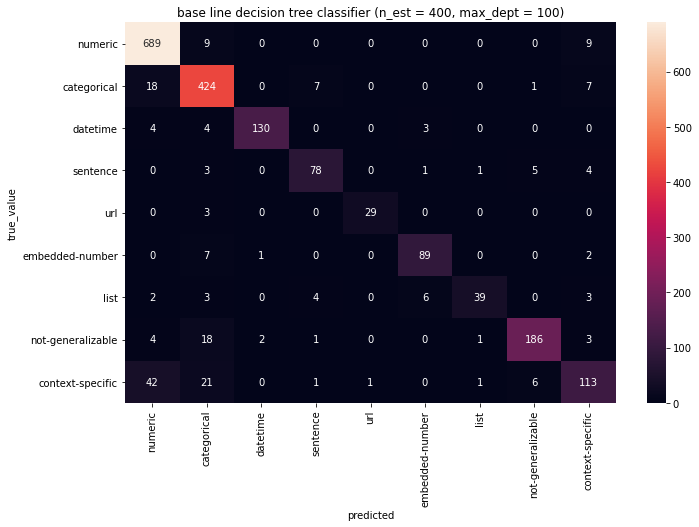

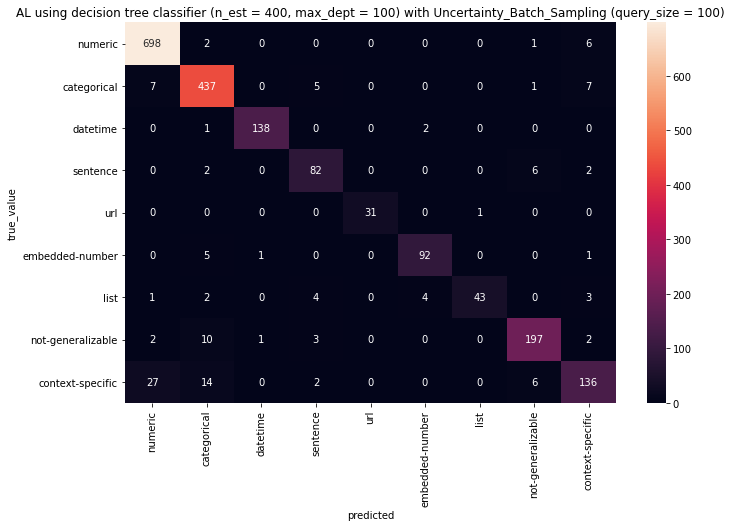

In [14]:
#for qs in [10]:
#    train_this(n_est=400, max_dept=100, query_size=qs, max_feed = 1000)

feed_his_folder = "./feed"
         
for qs in [100]:
    feed_his =None
    try:
        file_name = f"Uncertainty_Batch_Sampling_ne400_dept100_query{qs}"
        feed_his = load_feed(f"{feed_his_folder}/{file_name}.pkl")
    except:
        print(f"feed history for qs {qs} not found, starting fresh")
    train_this(n_est=400, max_dept=100, query_size=qs, max_feed = 6349, feed_his=feed_his)

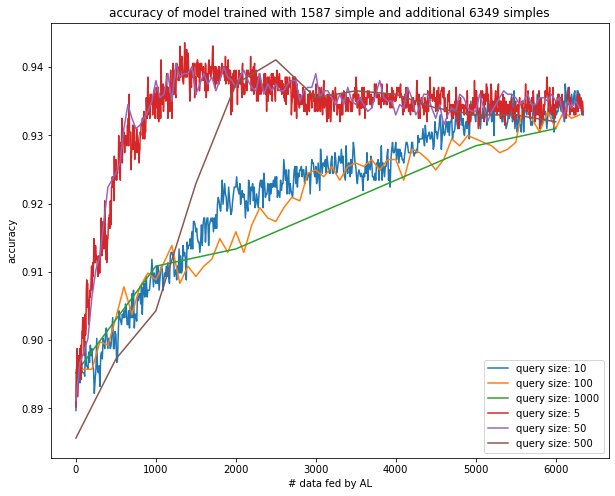

In [13]:
path = "./his"
files = sorted(os.listdir(path))

def get_results():
    for f in files:
        if f.endswith(".csv") and not f.startswith("test"):
            with open(f"{path}/{f}", mode='r') as infile:
                reader = csv.reader(infile)
                temp = zip(*reader)

                results = {"filename": f}
                for i in temp:
                    results[i[0]] = i[1:]
                yield results

plt.figure(figsize=(10,8))

for r in get_results():
    num_q = [int(num) for num in r["num_queries"]]
    test_a = [float(num) for num in r["test_accuracy"]]
    if (max(num_q) > 5000):
        plt.plot(num_q, test_a, label = "query size: " + r["filename"][46:-4])
    
plt.title("accuracy of model trained with 1587 simple and additional 6349 simples")
plt.xlabel("# data fed by AL")
plt.ylabel("accuracy")
#plt.xticks(np.arange(0, 6000, 1000))
#plt.yticks(np.arange(0, 140, 10))
plt.legend()
plt.savefig("acc_plot.png")
plt.show()

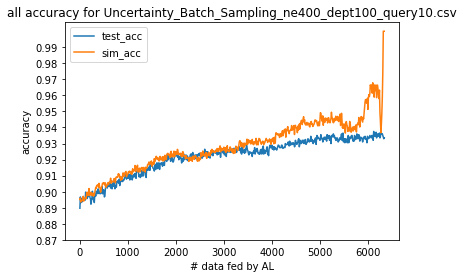

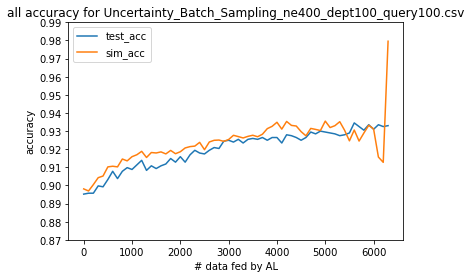

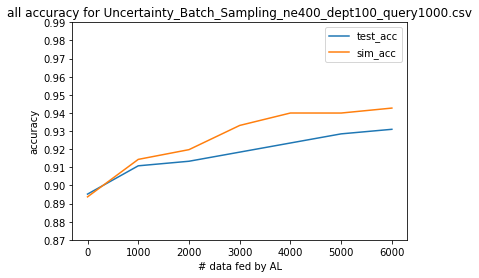

No handles with labels found to put in legend.


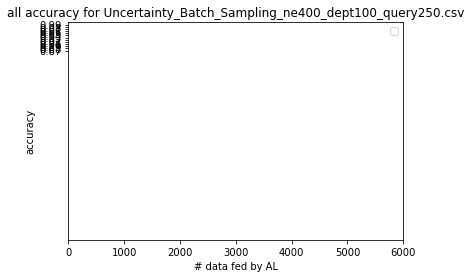

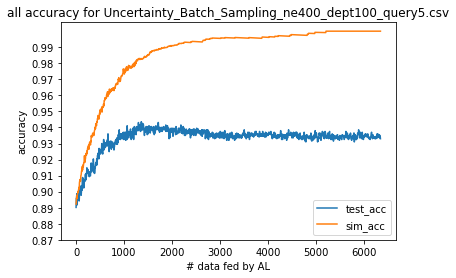

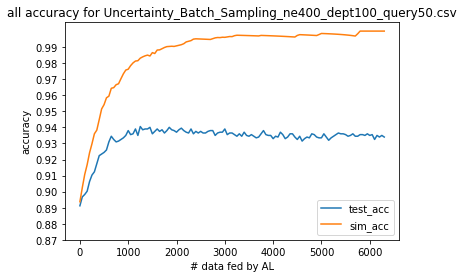

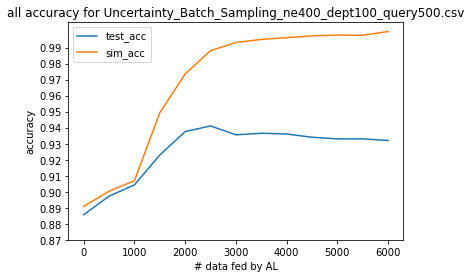

No handles with labels found to put in legend.


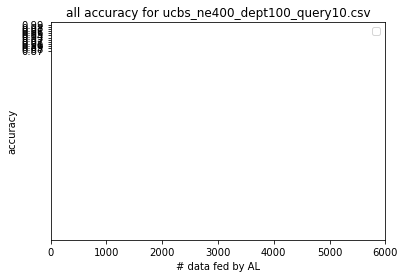

In [16]:
for r in get_results():
    num_q = [int(num) for num in r["num_queries"]]
    
    if (max(num_q) > 5000):
        test_acc = [float(num) for num in r["test_accuracy"]]
        sim_acc = [float(num) for num in r["simulation_accuracy"]]
        
        plt.plot(num_q, test_acc, label = "test_acc")
        plt.plot(num_q, sim_acc, label = "sim_acc")
        #if "train_accuracy" in r:
        #    plt.plot(num_q, r["train_accuracy"], label = "train_acc")
    
    plt.title(f"all accuracy for { r['filename'] }")
    plt.xlabel("# data fed by AL")
    plt.ylabel("accuracy")
    plt.xticks(np.arange(0, 7000, 1000))
    plt.yticks(np.arange(0.87, 1, 0.01))
    plt.legend()
    plt.show()

processing ./feed/Uncertainty_Batch_Sampling_ne400_dept100_query10.pkl
6350.0


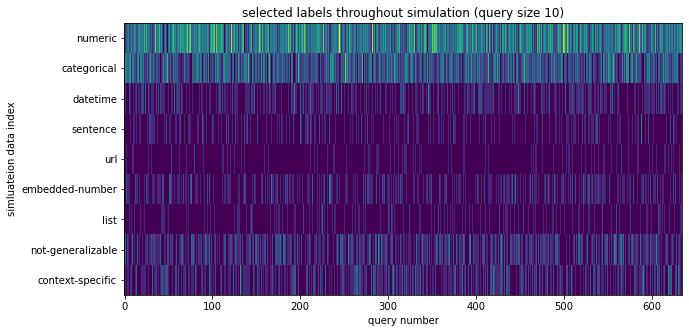

processing ./feed/Uncertainty_Batch_Sampling_ne400_dept100_query100.pkl
6400.0


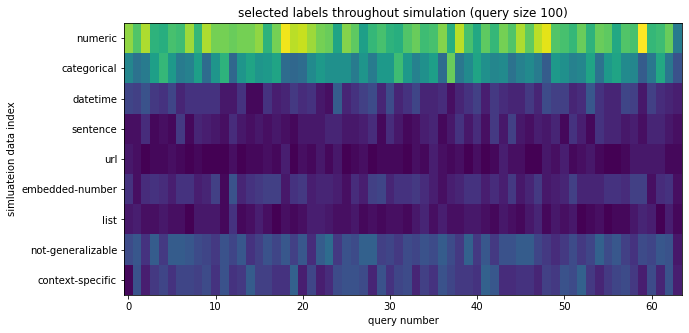

processing ./feed/Uncertainty_Batch_Sampling_ne400_dept100_query1000.pkl
7000.0


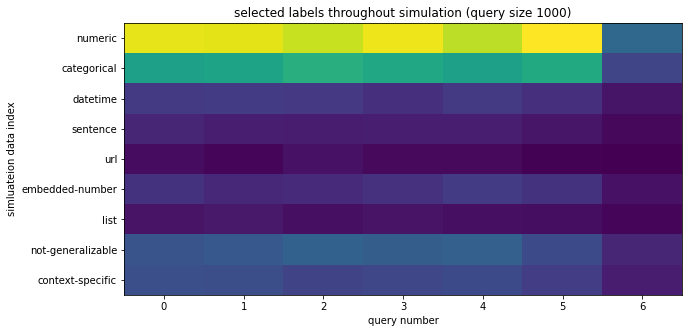

In [17]:


def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

def find_total_feed_order(feed, query_size, max_feed):
    re = np.zeros( max_feed )
    mask = np.zeros(max_feed)
    
    for i, fe in enumerate(feed):
        for elem in fe:
            x_till_index = int(elem)
            for j in range(len(re)):
                
                if x_till_index <= 0 and re[j] == 0:
                    re[j] = (i+1) * query_size
                    break
                elif re[j] == 0:
                    x_till_index -= 1
                    
            
    print(max(re))
    return re

path = "./feed"
for q in [10,100,1000]:
    all_feed = {}
    max_feed = 6349
    all_feed_np = np.zeros((q, 6349))


    file_path = f"{path}/Uncertainty_Batch_Sampling_ne400_dept100_query{q}.pkl"
    feed = load_feed(file_path)


    print("processing", file_path)
    re = find_total_feed_order(feed, q, max_feed)

    re_re = defaultdict(list)
    for i, v in enumerate(re):
        re_re[v].append(i)

    re_re.pop(0)
    np_re = np.zeros((len(re_re), 9))

    i = 0
    for k,v in sorted(re_re.items()):
        temp = Counter(y_sim.iloc[v].to_numpy().reshape(-1))
        temp_list = [0]*9
        for kk,vv in temp.items():
            temp_list[int(kk)] = vv
        re_re[k] = temp_list
        np_re[i,:] = temp_list
        i+= 1
    #print(*sorted(re_re.items()), sep="\n")
    #print(np_re)
    plt.figure(figsize = (10,5))
    plt.ylabel("simluateion data index")
    plt.xlabel("query number")
    plt.yticks(ticks = range(9), labels = dict_label_list, rotation=0)
    plt.title(f"selected labels throughout simulation (query size {q})")
    plt.imshow(np_re.T, aspect='auto', interpolation='nearest')
    plt.savefig(f"selected_labels_query_size_{q}.png")
    plt.show()

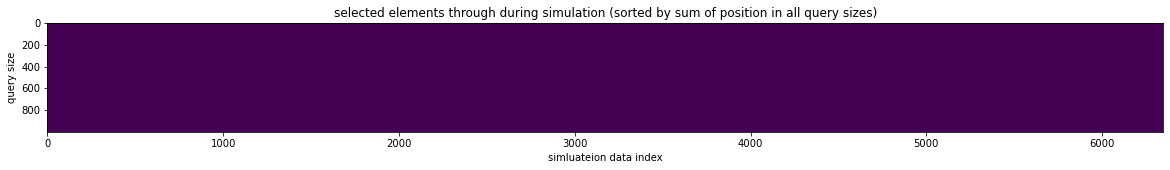

In [18]:

sorted_feed = all_feed_np[:,np.argsort(all_feed_np.sum(axis=0))[::-1]]
plt.figure(figsize = (20,2))
plt.xlabel("simluateion data index")
plt.ylabel("query size")

plt.title("selected elements through during simulation (sorted by sum of position in all query sizes)")
plt.imshow(sorted_feed, aspect='auto', interpolation='nearest')
plt.show()

In [19]:
load_feed(f"{his_folder}/class_his_{file_name}.pkl")

[array([0.97454031, 0.92778993, 0.92198582, 0.84782609, 0.90625   ,
        0.8989899 , 0.68421053, 0.86511628, 0.61081081]),
 array([0.97312588, 0.93435449, 0.92907801, 0.83695652, 0.875     ,
        0.8989899 , 0.70175439, 0.8744186 , 0.59459459]),
 array([0.96746818, 0.93654267, 0.93617021, 0.82608696, 0.9375    ,
        0.90909091, 0.68421053, 0.86511628, 0.61081081]),
 array([0.9688826 , 0.9321663 , 0.92907801, 0.81521739, 0.96875   ,
        0.90909091, 0.70175439, 0.88372093, 0.63783784]),
 array([0.96605375, 0.93654267, 0.90070922, 0.86956522, 0.90625   ,
        0.91919192, 0.70175439, 0.8744186 , 0.64324324]),
 array([0.97171146, 0.92778993, 0.92198582, 0.85869565, 0.9375    ,
        0.91919192, 0.70175439, 0.89302326, 0.64864865]),
 array([0.97454031, 0.92997812, 0.93617021, 0.89130435, 0.9375    ,
        0.91919192, 0.71929825, 0.88372093, 0.65945946]),
 array([0.97029703, 0.92997812, 0.93617021, 0.88043478, 0.875     ,
        0.90909091, 0.68421053, 0.86976744, 0.6810